# Project ADA LJ

Mount DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

## Install dependencies

In [ ]:
!pip install nltk gensim spacyn

In [ ]:
!pip install pyLDAvis

In [ ]:
pip install vaderSentiment 

In [ ]:
pip install empath

In [ ]:
!python -m spacy download en 

In [ ]:
!python -m nltk.downloader punkt 

In [ ]:
!python -m nltk.downloader all-corpora 

In [ ]:
!pip install pandas==1.3.0 #have to downgrade to use on colab

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')

#loading and preprocessing
import pandas as pd
import bz2
import json
from os import listdir
from collections import Counter


import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#wordcloud
import re


#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
from nltk.stem import WordNetLemmatizer

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#Bert Realated imports
#think prob just leave those imports in those parts

#gunshot dataset and plots
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats



## Load all the pre-processed chunks into one dataframe and first exploratory analysis.

In [ ]:
#all the needed datasets are on one folder path in one drive
FOLDER_PATH = '/content/drive/MyDrive/datasets_ADA/'
#every time I have to retrieve just take this + specific folder i Need

In [ ]:
# Function which sequentially opens all pre-processed chunks and saves them to a single list
def open_chunks(year, list_dfs):
    #common_path = '/content/drive/MyDrive/projectada/Processed_dfs/processed_dfs/' epfl drive
    common_path = '/content/drive/MyDrive/datasets_ADA/processed_dfs/'#personal drive
    file_name = 'chunk_with_keyword.pkl'
    
    for file in listdir(common_path + str(year) + '/'):
        
        # Macs generate a hidden ".DS_Store" file which contains MetaData about the folder content.
        # The listdir() will identify this file, so we skip over this iterate of the for loop as the
        # function will otherwise fail. 
        if file == '.DS_Store':
            continue
            
        small_df = pd.read_pickle(common_path + str(year) + '/' + file, compression='infer')
        list_dfs.append(small_df)
    
    return list_dfs


In [ ]:
# Iterate over all years of data instantly
years = [2015, 2016, 2017, 2018, 2019]

# The final dataframe to store the filtered Quote Bank data:
final_df = pd.DataFrame()

# execute the open_chunks function for all years of dataset and save the result to final_df: 
for year in years: 
    list_dfs = []
    temp_df = pd.concat(open_chunks(year, list_dfs), ignore_index=True)
    final_df = pd.concat([final_df, temp_df])
    

In [ ]:
final_df.head()

,speaker,qids,date,quotation,keyword
12963,None,[],2015-10-04 21:41:18,I get that there's a spree of crime and gun vi...,gun violence
18137,None,[],2019-08-15 00:30:00,"Because of that status, regulations in regards...",firearm
32063,Marty Moylan,[Q6777503],2018-02-21 08:15:51,I think the problem you have is you have peopl...,firearm
12212,Randy Jurgensen,[Q16093841],2018-09-29 13:36:56,Most school shootings are done by students and...,school shooting
7899,Terry McGuire,[Q7704785],2015-12-04 11:57:00,"Those people yesterday had bombs. I mean, Fran...",gun law
12500,Madeline Singas,[Q37980155],2019-04-09 00:43:00,This case is yet another example of the brutal...,gun violence
10600,Bernard Hogan-Howe,[Q2898066],2016-08-04 09:27:20,"Every day in London, my officers patrol and ca...",firearm
15250,Rick Perry,[Q215057],2015-07-26 23:12:31,I think that you allow the citizens of this co...,firearm
12549,Mitzi Johnson,[Q28154985],2018-03-05 15:14:35,The State House was packed this week with midd...,gun violence
23694,None,[],2018-05-21 18:30:00,"Obviously it WILL HAPPEN AGAIN, and again and ...",gun control


In [ ]:
print('We have %d quotes' % final_df.shape[0])

(119535, 5)

In [ ]:
#quotes.isnull().values.any() #check if any nans, following is a faster way of doing this
final_df.info() #no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119535 entries, 0 to 26266
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   speaker    119535 non-null  object        
 1   qids       119535 non-null  object        
 2   date       119535 non-null  datetime64[ns]
 3   quotation  119535 non-null  object        
 4   keyword    119535 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.5+ MB


In [ ]:
#just wanna count how many None for the speakers
df_unk = final_df.query("speaker == 'None'")
print("We have %d quotes with unknown speakers" % df_unk.shape[0])

We have 44571 quotes with unknown speakers


Exploring how many duplicates. Maybe some unkwown speakers might have the same quotes as some assigned speakers.

In [ ]:
quotes = final_df.drop_duplicates(subset=['speaker', 'quotation'])
print('We have %d unique speaker-quotation combinations' % quotes.shape[0]) #same uniq speaker quot combination

We have 119535 unique speaker quotation combinations


In [ ]:
print('We have %d unique speakers.' % quotes['speaker'].unique().size)
print('We have %d unique quotations.' % quotes['quotation'].unique().size)

We have 18850 unique speakers.
We have 119535 unique quotations.


All quotations are unique :)

## Preprocessing I (polishing of quotation text)

Look for unwanted characters in the quotes like \n, unescaped html tags like \<p\> or nbsp (from the original html dump) and typical characters encoding errors.

In [ ]:
quotes[quotes['quotation'].str.contains('\n',regex=False)] #no /n (new line)

,speaker,qids,date,quotation,keyword


In [ ]:
quotes[quotes['quotation'].str.contains('<p>',regex=False)]  #no <p>

,speaker,qids,date,quotation,keyword


In [ ]:
quotes[quotes['quotation'].str.contains('\<p\>',regex=False)] #no need to filter with regex suggested on ADA problems form

In [ ]:
quotes[quotes['quotation'].str.contains('™',regex=False)] #there seems to be very few character encoding errors

,speaker,qids,date,quotation,keyword
1943,None,[],2015-08-27 20:05:26,Our first quarter results exceeded our expecta...,firearm
2098,None,[],2015-04-15 20:48:23,In reaffirming the greatness of our nation we ...,"legal gun, legal gun"
14181,President Obama,[Q76],2015-06-20 23:44:21,"But let'€ ™ s be clear: at some point, we as a...",gun violence
6169,Sean McCarthy,"[Q17018089, Q27306143, Q7441218, Q7459558, Q74...",2017-10-20 07:15:00,By gaining exclusive distribution rights to Di...,firearm
12524,Matt Lauer,[Q1100609],2017-07-24 13:18:57,"No, I'm not suggesting that, Matt. I'm telling...","gun owner, gun ownership"
16469,Tom Myers,"[Q26971990, Q7816995, Q7816996, Q7816998]",2017-10-10 14:25:06,We found that the firearms and knife industrie...,firearm
9154,Charlie Baker,"[Q28051620, Q5076629, Q5084482, Q56254750]",2018-07-03 21:40:23,creates a responsible way to help prevent gun ...,"gun death, gun death"
22081,None,[],2018-08-07 10:30:04,I must consider that Mr. Payne obtained and po...,firearm


In [ ]:
quotes[quotes['quotation'].str.contains('â',regex=False)] #there seems to be very few character encoding errors

,speaker,qids,date,quotation,keyword
2098,None,[],2015-04-15 20:48:23,In reaffirming the greatness of our nation we ...,"legal gun, legal gun"
14181,President Obama,[Q76],2015-06-20 23:44:21,"But letâ € ™ s be clear: at some point, we as ...",gun violence
1680,None,[],2017-10-13 00:37:18,FILE - This undated file photo provided by Eri...,mass shooting
2062,Greg O'Connor,"[Q28600237, Q5606067]",2017-02-18 20:55:17,My position is that arming is inevitable unles...,"firearm, legal gun, legal gun"
9116,None,[],2017-06-20 16:38:50,"According to their rhetoric, this is everythin...",firearm
12524,Matt Lauer,[Q1100609],2017-07-24 13:18:57,"No, I'm not suggesting that, Matt. I'm telling...","gun owner, gun ownership"
12630,DC Young Fly,[Q24895237],2017-10-03 00:40:46,"Last night in Las Vegas, a horrible tragedy to...",mass shooting
15114,None,[],2017-12-18 19:16:25,The main reason I hated ALICE Drill days was t...,mass shooting
15297,Tim Fischer,"[Q1367112, Q7803493, Q7803494]",2017-10-06 21:40:56,"Since 1996, since Port Arthur, since the gun l...","mass shooting, gun law"
15707,President Trump,[Q22686],2017-10-05 16:04:14,Weâ   ll be talking about gun laws as time g...,gun law


In [ ]:
quotes = quotes[~quotes['quotation'].str.contains('â')]

In [ ]:
quotes[quotes['quotation'].str.contains('â',regex=False)]

,speaker,qids,date,quotation,keyword


In [ ]:
quotes = quotes[~quotes['quotation'].str.contains('™')]

In [ ]:
quotes[quotes['quotation'].str.contains('™',regex=False)]

,speaker,qids,date,quotation,keyword


In [ ]:
quotes[quotes['quotation'].str.contains('¢',regex=False)] #no occurences

,speaker,qids,date,quotation,keyword


In [ ]:
quotes[quotes['quotation'].str.contains('Å',regex=False)] #no occurences

,speaker,qids,date,quotation,keyword


In [ ]:
quotes[quotes['quotation'].str.contains('Æ',regex=False)] #no occurences

,speaker,qids,date,quotation,keyword


In [ ]:
quotes[quotes['quotation'].str.contains('¥',regex=False)] #no occurences

,speaker,qids,date,quotation,keyword


There seems to be no particular character encodings errors, even without a more precise regex search we are relatively satisfied.

Depending on the sentimental analysis tools (if is able to handle social media text or not) we might need to see if we have quotes with social media like text and how to handle those. Given that the original corpus came from news there might be some reported quotes from social media.

For example we see that very few quotes have characters like "@" for twitter handles or typical gergal expression like "WTF".

In [ ]:
quotes[quotes['quotation'].str.contains('@',regex=False)]

In [ ]:
quotes[quotes['quotation'].str.contains('WTF',regex=False)]

In [ ]:
#consider more extreme cleaner for non alphanumerical character while keeping pucntations important for sentimental analysis
'''def cleaner(df):
    "Extract relevant text from DataFrame using a regex"
    # Regex pattern for only alphanumeric, hyphenated text with 3 or more chars
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    df['clean'] = df['content'].str.findall(pattern).str.join(' ')
    if limit > 0:
        return df.iloc[:limit, :].copy()
    else:
        return df

df_preproc = cleaner(df)
df_preproc.head(3)'''

#maybe just alpha numeric, punctuactions and hyphenated text with 3 or more chars

Quickly check if it's worth polishing for some weird extra  numerical characters, (vader given that it was built on social media data should be able to handle it but ultimately if we wanna use also other sentiment analysis tool might be better to clean it)

## Preprocessing II (data visualization, exploaration and quotes selection)

### Word cloud visualization with unfiltered dataset

In [ ]:
#let's first visualize all the quotes in a nice way, redo it with better polishing pipeline nlp (migh be very similar), create custom stopwords from doc to remove some
#words like going kind etc...
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [ ]:
corpus = text_transformation(quotes['quotation'])
#took 9 mins to run

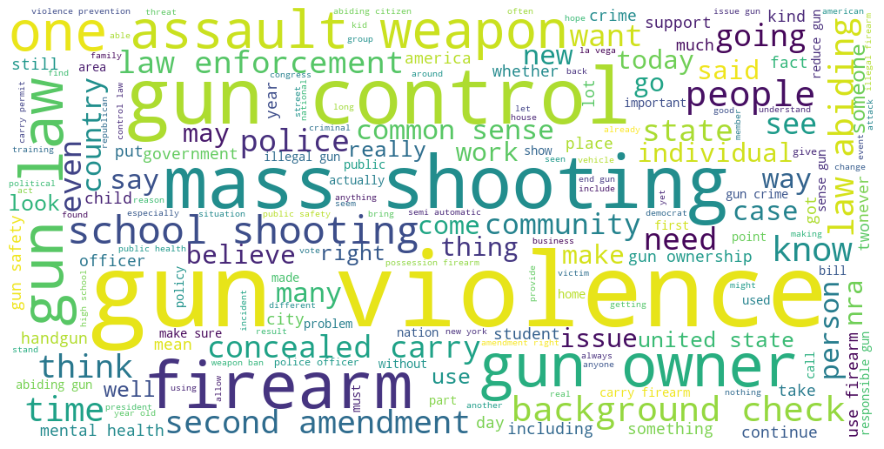

In [ ]:
plt.rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)
plt.grid('False')
plt.xticks([])
plt.yticks([])
plt.show()
#takes a bit

Consider either doing it just a the beginning with the og dataset or just after having finalized all the filtering of the quotes.

### Speakers and keywords distriubtion/analysis plus why dropping unkwown speakers

keywords

In [ ]:
d = Counter(list(zip(quotes.keyword)))
D = pd.DataFrame.from_dict(d, orient='index').reset_index()
D = D.rename(columns={'index':'Keyword', 0:'Keyword frequency'})
D = D.sort_values('Keyword frequency', ascending=False)
D.head(30)

,Keyword,Keyword frequency
2,"(firearm,)",42657
1,"(gun violence,)",21086
7,"(gun control,)",9668
9,"(mass shooting,)",8128
6,"(gun law,)",5157
5,"(gun owner,)",4850
18,"(school shooting,)",4394
3,"(assault weapon,)",4241
8,"(handguns,)",2126
11,"(concealed carry,)",1842


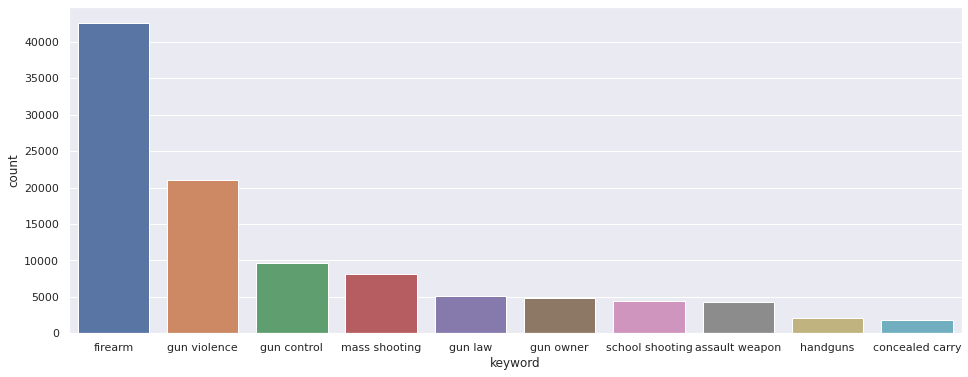

In [ ]:
plt.figure(figsize=(16, 6))
sns.set_theme(style="darkgrid")
sns.countplot(quotes['keyword'], order=quotes['keyword'].value_counts().iloc[:10].index)

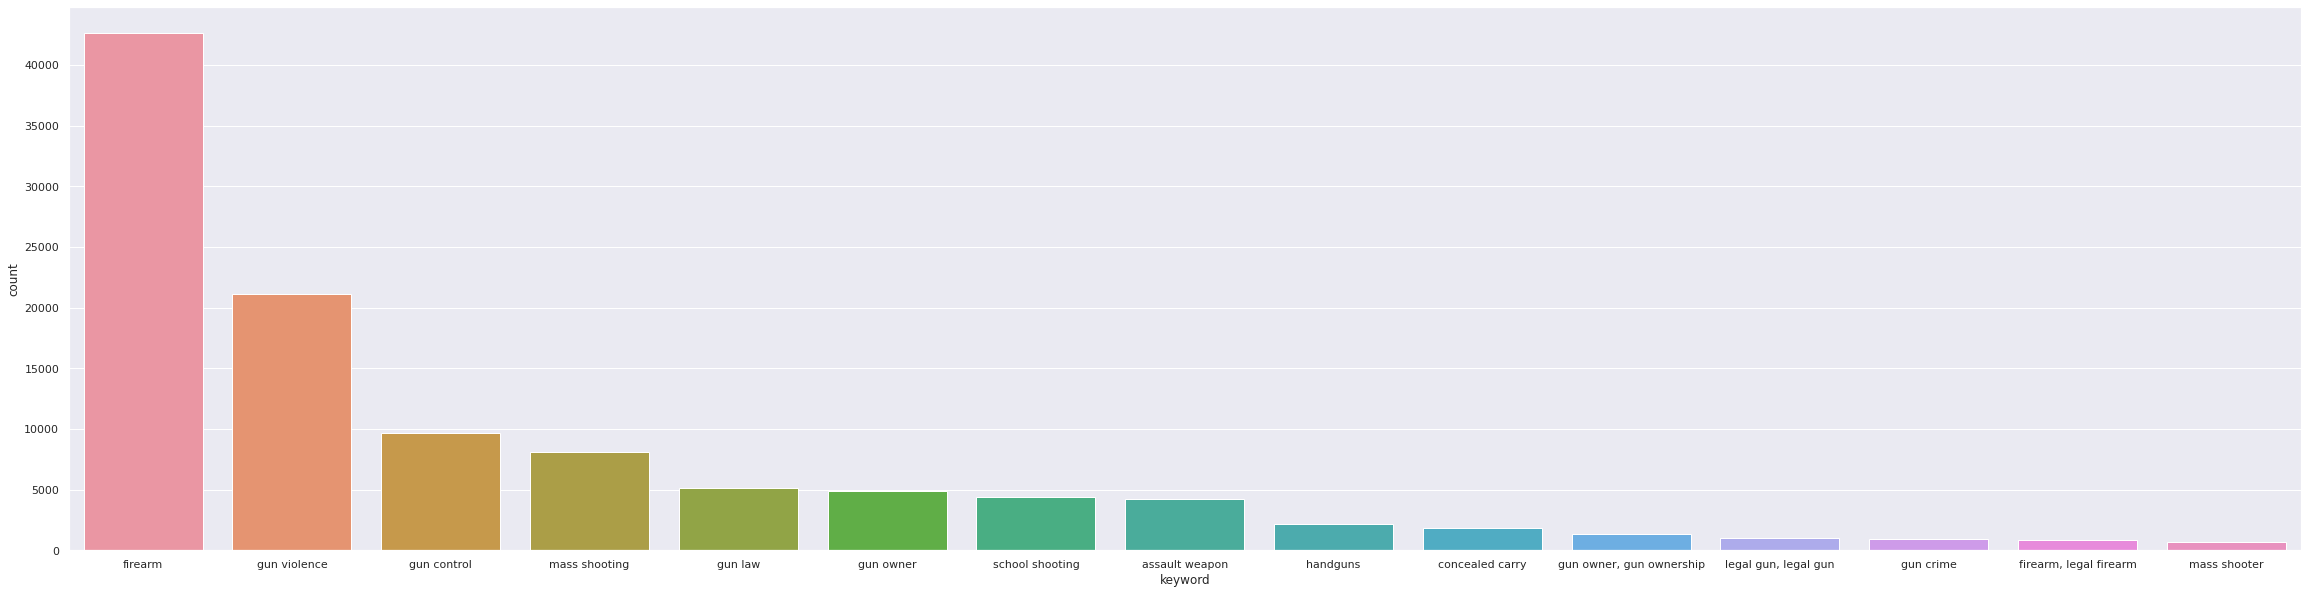

In [ ]:
plt.figure(figsize=(40, 10))
sns.set_theme(style="darkgrid")
sns.countplot(quotes['keyword'], order=quotes['keyword'].value_counts().iloc[:15].index)

Speakers

In [ ]:
#count how many quotes par speaker
c = Counter(list(zip(quotes.speaker)))
C = pd.DataFrame.from_dict(c, orient='index').reset_index()
C = C.rename(columns={'index':'Speaker', 0:'Total count of quotes par speaker'})
C = C.sort_values('Total count of quotes par speaker', ascending=False)
C.head(10)

,Speaker,Total count of quotes par speaker
0,"(None,)",44571
37,"(Hillary Clinton,)",587
41,"(President Barack Obama,)",480
3716,"(President Donald Trump,)",477
282,"(Chris Murphy,)",449
1,"(President Obama,)",443
130,"(Alan Gottlieb,)",438
31,"(Nancy Pelosi,)",366
35,"(Bernie Sanders,)",334
273,"(Dana Loesch,)",321


In [ ]:
plt.figure(figsize=(16, 6))
sns.set_theme(style="darkgrid")
sns.countplot(quotes['speaker'], order=quotes['speaker'].value_counts().iloc[:10].index)

Better explain why we decide to remove the unkwown speakers:

- create a better balanced dataset speaker wise (higly skewed towards unkwown speakers)

- Given that our research questions focus more on overall sentiment, would be better to just choose attributed speakers quotes -> better representation of overall sentiment

- unkwown speakers may contribute even more to noise (double check with topic distribution and hints of this in the updated keywords distributions; related to the fact as shown after than firearm, assault wepaon and potentially concealed carry/gun owner were more present in unkwown speakers

In [ ]:
#check the keyword distribution just in unkwown speakers vs only attributed quotes
#use query and copy and paste code before for keyword distribution

In [ ]:
#do version just unkwown speakers with query

In [ ]:
filt_quotes = quotes.query("speaker !='None")
#version without unkwown speakers, just have to adjust the dataset name
d = Counter(list(zip(filt_quotes.keyword)))
D = pd.DataFrame.from_dict(d, orient='index').reset_index()
D = D.rename(columns={'index':'Keyword', 0:'Keyword frequency'})
D = D.sort_values('Keyword frequency', ascending=False)
D.head(10)

interesting if compared with unkwown dataset lot of quote were just firearm and gun violence.

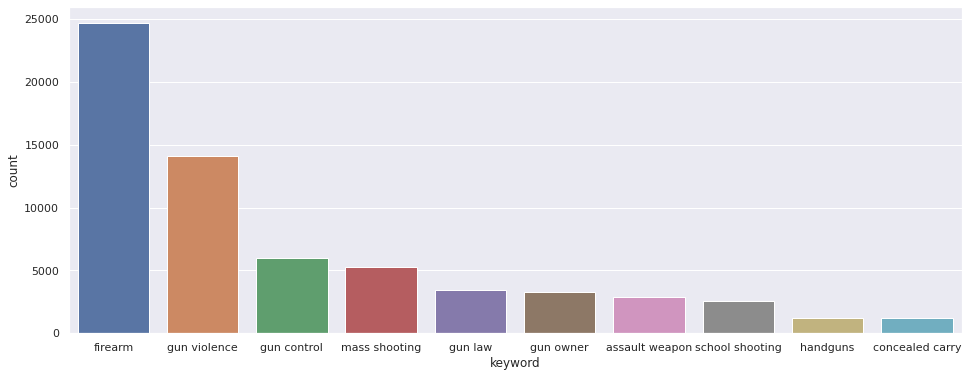

In [ ]:
plt.figure(figsize=(16, 6))
sns.set_theme(style="darkgrid")
sns.countplot(filt_quotesquotes['keyword'], order=filt_quotesquotes['keyword'].value_counts().iloc[:10].index)

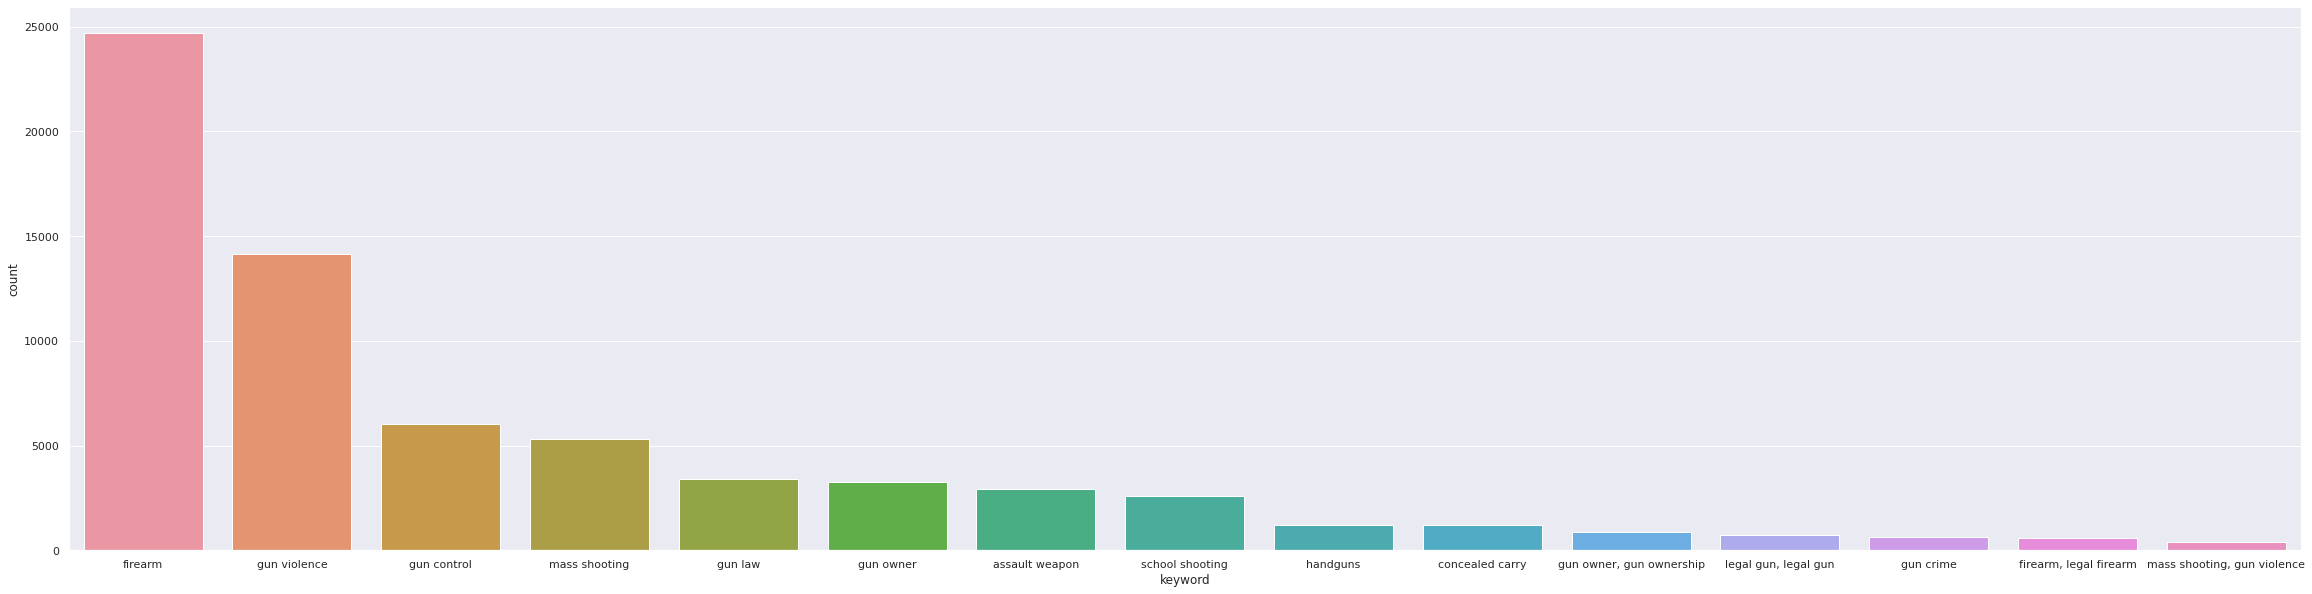

In [ ]:
plt.figure(figsize=(40, 10))
sns.set_theme(style="darkgrid")
sns.countplot(filt_quotesquotes['keyword'], order=filt_quotesquotes['keyword'].value_counts().iloc[:15].index)

Speakers

We'll just drop all the quotes with unkwown speakers. Maybe just keep N of quotes over time compared to gunshot datasets, comparing it to the one filtered with no unkwown speakers/further filtered quotations.

In [ ]:
filtered_quotes = quotes.copy(deep=True)

In [ ]:
filtered_quotes.query("speaker == 'None'")

,speaker,qids,date,quotation,keyword
0,None,[],2015-12-07 01:54:26,cannot identify every would-be mass shooter.,mass shooter
12,None,[],2015-12-07 05:32:39,"Yes, we need more gun control, and yes, we nee...",gun control
13,None,[],2015-11-03 17:59:00,This epidemic of gun violence knows no boundar...,gun violence
14,None,[],2015-09-30 13:02:40,"Unfortunately, we have been besieged with a mi...",firearm
17,None,[],2015-06-19 19:51:51,"Eight of his church members, who might be aliv...",handguns
...,...,...,...,...,...
26258,None,[],2019-11-28 15:36:15,We believe this may very well be a record numb...,gun violence
26259,None,[],2019-05-23 09:53:51,We have to take the firearm in. We have to inv...,firearm
26264,None,[],2019-11-24 14:15:58,"Giffords: Courage to Fight Gun Violence,",gun violence
26265,None,[],2019-10-21 17:43:34,If homegrown individual candidates with compel...,gun control


In [ ]:
filtered_quotes = filtered_quotes.query("speaker != 'None'").reset_index(drop=True)

In [ ]:
filtered_quotes

,speaker,qids,date,quotation,keyword
0,President Obama,[Q76],2015-07-23 10:46:00,If you look at the number killed by gun violen...,gun violence
1,Jim Wallace,"[Q16751191, Q333807, Q6145053, Q6198737, Q6198...",2015-04-21 10:05:54,It's $100 for the Firearm Identification Card ...,firearm
2,Donald Trump,"[Q22686, Q27947481]",2015-09-19 05:27:02,"scary sounding phrases like `assault weapons,'...",assault weapon
3,President Obama,[Q76],2015-12-02 22:42:13,It's still an active situation. FBI is on the ...,"mass shooting, firearm"
4,Marion Hammer,[Q6765215],2015-03-09 20:52:42,The recent shooting on the FSU campus and the ...,firearm
...,...,...,...,...,...
74923,Scott Wiener,[Q7437504],2019-12-11 10:07:09,United Playaz gives me hope... hope that worki...,gun violence
74924,Richard Blumenthal,[Q2023708],2019-03-26 00:00:00,We've got to ask the questions of our friends ...,gun violence
74925,Cory Booker,[Q1135767],2019-05-15 00:00:00,a 40% drop in gun homicides,gun homicide
74926,Eric Swalwell,[Q3466996],2019-02-04 20:48:28,After 6 yrs of working in Congress to end gun ...,gun violence


In [ ]:
filtered__quotes.query("speaker == 'None'") #double check that removal was successful

,speaker,qids,date,quotation,keyword


## Sentiment Analysis Vader

### Sentiment analysis

decided to use vader bc designed for social media where sentiment very polarized. Especially concerning this context we think it makes more sense. You can see that some typical characters only present in social media are in the dataset.


Also unlike with some supervised methods of NLP, preprocessing necessities such as tokenisation and stemming/lemmatisation are not required. You can pretty much plug in any body of text and it will determine the sentiment.
VADER is even smart enough to understand the valence of non-conventional text, including emojis (i.e. :-( ), capitalisation (i.e. sad vs SAD) and extended punctuation (i.e. ? vs ???). This is what makes the module so good at analysing social media text. Additionally, VADER removes stop words automatically so there is no need to do so yourself.

see if it makes sense to use tools more for social media and see if bimodal distribution at the end to justify choice of vader in the first place.

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner']) #remove parts to load quicker

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
def sent_an(text): #get polarity scores, no need for preprocessing with vader
  return analyzer.polarity_scores(text)

In [ ]:
filtered_quotes['scores'] = filtered_quotes['quotation'].apply(sent_an) #apply functin to each quote in the dataframe

In [ ]:
filtered_quotes['compound'] = filtered__quotes['scores'].apply(lambda score_dict: score_dict['compound']) #create new column with compound

In [ ]:
filtered_quotes['sent_type']='' #create new column with sentiment type based on compound, consider changing tresholds
filtered_quotes.loc[filtered_quotes.compound>=0.05,'sent_type']='POS'
filtered_quotes.loc[(filtered_quotes.compound<0.05) & (filtered_quotes.compound>-0.05),'sent_type']='NEU'
filtered_quotes.loc[filtered_quotes.compound<=-0.05,'sent_type']='NEG'

Text(0, 0.5, 'Number of quotes')

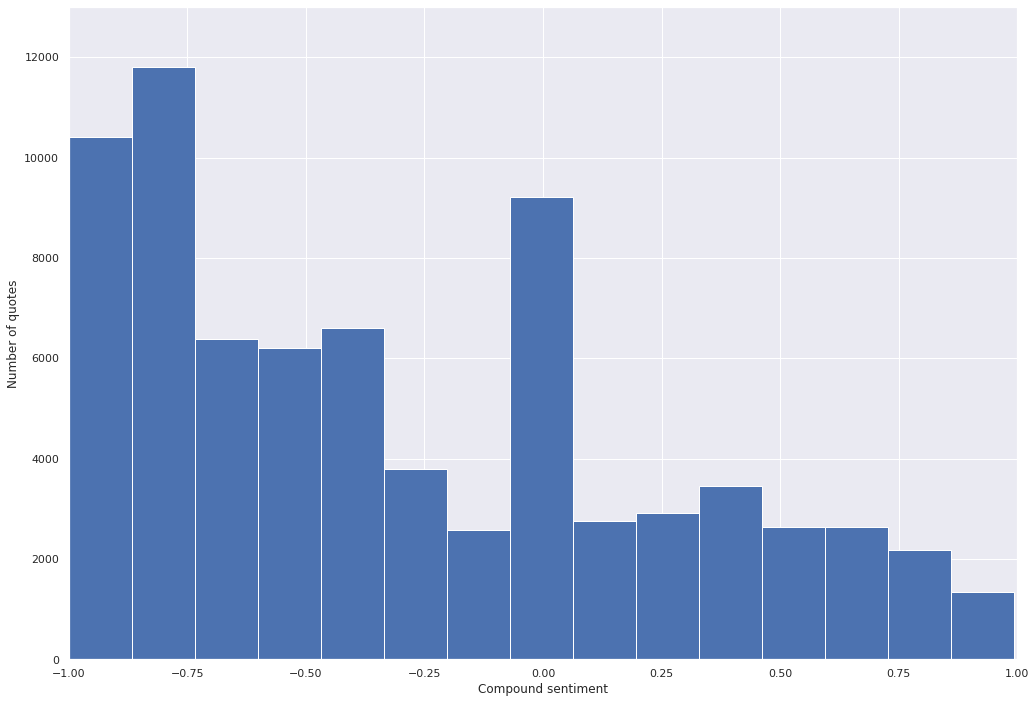

In [ ]:
plt.figure(figsize=(17, 12))
filtered_quotes.compound.hist(bins=15)
plt.xlim([-1,1])
plt.ylim([0,13000])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of quotes')

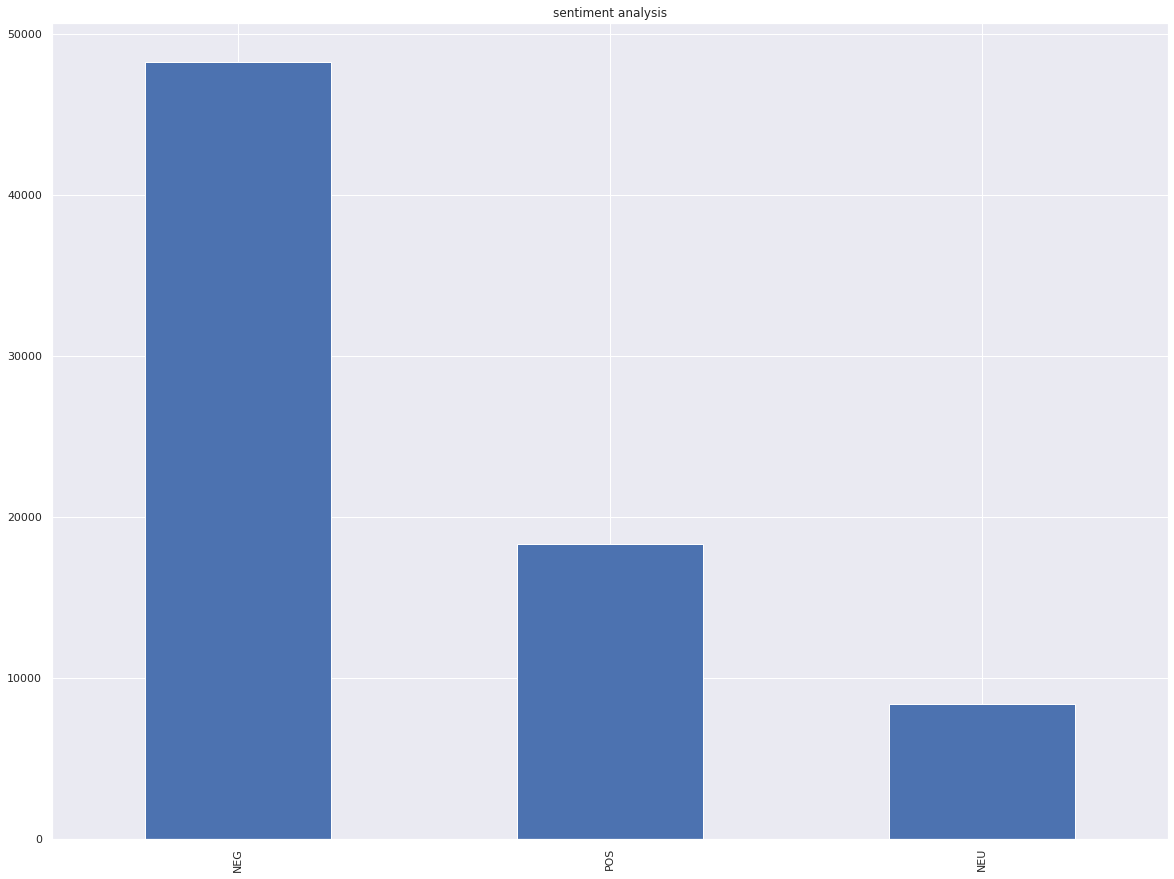

In [ ]:
plt.figure(figsize=(20, 15))
filtered_quotes.sent_type.value_counts().plot(kind='bar',title="sentiment analysis")

We obtain significantly skewed results. We suspect that this is a consequence of the Vader sentiment analyisis struggling to properly classify the quotes properly. We would have expected a more bimodal distribution-like.

Looking at some quotes, some are really hard to classify even for a human reader (can show some by printing certain neutral quotes).

In [ ]:
#.....

In additon to the previous point Vader is a statistical model not able to get the contexts of the words and given that we expect all the quotes to be sentiment wise very strong the model might struggle to properly classify baising towards very negative sentiment.

Let's see some example of very negative and positive examples.

In [ ]:
neg = filtered_quotes.query("compound < -0.5")

In [ ]:
for i in range(20):
  print(neg.iloc[i,3])
  print('/n')

In [ ]:
pos = filtered_quotes.query("compound > 0.5")

In [ ]:
for i in range(20):
  print(pos.iloc[i,3])
  print('/n')

It's still an active situation. FBI is on the ground offering assistance to local officials as they need it. It does appear that there are going to be some casualties. And, obviously our hearts go out to the victims and the families. The one thing we do know is that we have a pattern now of mass shootings in this country that has no parallel anywhere else in the world. And there are some steps we could take not to eliminate every one of these mass shootings, but to improve the odds that they don't happen as frequently: common-sense gun safety laws, stronger background checks. And for those who are concerned about terrorism, some may be aware of the fact that we have a no-fly list where people can't get on planes, but those same people who we don't allow to fly could go into a store right now in the United States and buy a firearm and there's nothing that we can do to stop them. That's a law that needs to be changed. And so my hope is that we're able to contain this particular shooting,

These are just a small number of the total quotes but we can observe that despite few seem to be properly classified and related to the topic of gun violence most are either misclassified or do not seem to be that much related to the topic of gun violence.

To see if a better sentiment classifier migh yield better results we will use a more refined classifier which is able to account for context and should do a better job at properly classifying. We will compare the results with the Vader sentiment analysis tool which again being statistical gives more weight to the words alone.

However we still have to deal with the fact that some quotes still seem to be not specifically related to gun violence in general but to other topics. This has to do with the data itself and might impair our final analyiss. We therefore take some actions to further filter out some quotes to reduce the "noise/randomness" and try to keep the quotes as much related as possible to the topic of Gun Violence.

Most important thing after having performed all the sentiment analysis part (we will do the BERT part later in the notebook) is trying to filter even better specifically for gunshot violence specifically because even if sentimetn might work might be related slightly differen arguments which might invert polarity -> maybe just look at shift of sentiment or something similar so POS, NEG, NEU in particular topics like filter just for certain keywords or topics lda 

## Further filtering

The keywords *'firearm'* and  *'assault weapon'* seem to be associated with more general quotes and not specifically gun violence related ones (but when those keywords are together with other keywords quotes seem to be more related to gunshot violence discussion)

In [ ]:
#removed rows with two mentioned keywords
filtered_quotes = filtered_quotes.query("keyword != 'firearm'").reset_index(drop=True)

In [ ]:
filtered_quotes = filtered_quotes.query("keyword != 'assault weapon'").reset_index(drop=True)

In [ ]:
filtered_quotes = filtered_quotes.query("keyword != 'handguns'").reset_index(drop=True)

In [ ]:
filtered_quotes = filtered_quotes.query("N_of_tokens <= 160").reset_index(drop=True)

Explore the number of token for each quotation.

In [ ]:
def count_tok(text): 
  doc = nlp(text)
  words = [token.text for token in doc]
  return words

In [ ]:
filtered_quotes['tokens'] = filtered_quotes['quotation'].apply(count_tok)

In [ ]:
def long(text):
  return len(text)

In [ ]:
filtered_quotes['N_of_tokens'] = filtered_quotes['tokens'].apply(long)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


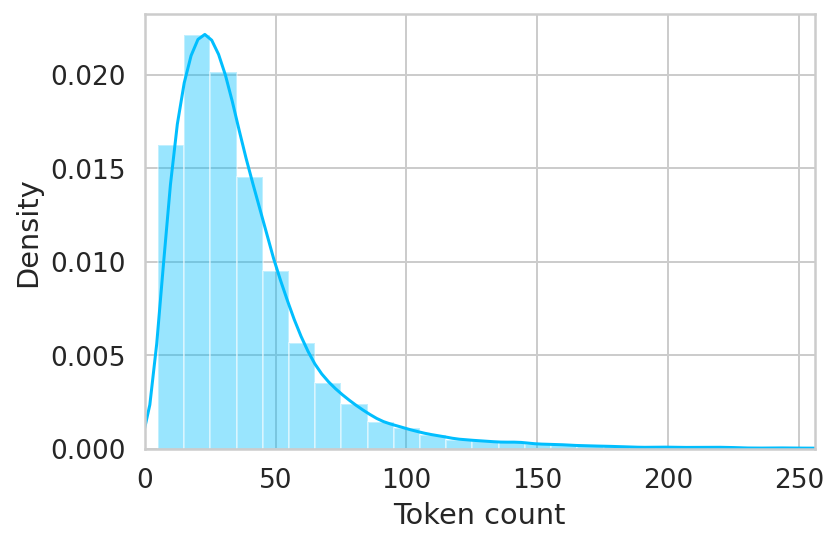

In [ ]:
sns.distplot(filtered_quotes['N_of_tokens'])
plt.xlim([0, 256]);
plt.xlabel('Token count');

We can observe that most of the quotes are less than 150 tokens long.

In [ ]:
#recheck bert part if I filtered out quotes with more than 100 tokesn (but for lenth)

In [ ]:
filtered_quotes.query("N_of_tokens < 5") #prblem seem to be related to firearm, one more reason to remove firearm

,speaker,qids,date,quotation,keyword,scores,compound,sent_type,tokens,N of tokens,N_of_tokens
43254,Cody Wilson,[Q5140474],2018-08-28 04:25:00,firearms up to.50 caliber,firearm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,NEU,"[firearms, up, to.50, caliber]",4,4
52391,Jeff Landry,[Q1686330],2018-03-27 16:09:38,loaded.38 caliber firearm.,firearm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,NEU,"[loaded.38, caliber, firearm, .]",4,4


In [ ]:
 filtered_quotes.query("N_of_tokens < 6") #some quotes seem to be meaningful others less, have to take decision on total number. For now we'll keep them.

,speaker,qids,date,quotation,keyword,scores,compound,sent_type,tokens,N of tokens,N_of_tokens
92,Kelly Keisling,[Q16151345],2015-02-09 22:59:50,break for gun owners.,gun owner,"{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...",-0.3400,NEG,"[break, for, gun, owners, .]",5,5
206,Tim McGraw,[Q356487],2015-04-15 15:00:00,protecting children from gun violence,gun violence,"{'neg': 0.684, 'neu': 0.316, 'pos': 0.0, 'comp...",-0.7579,NEG,"[protecting, children, from, gun, violence]",5,5
309,Gregg Jarrett,[Q5606548],2015-08-27 20:24:08,elevating gun deaths above terrorism,"gun death, gun death","{'neg': 0.7, 'neu': 0.3, 'pos': 0.0, 'compound...",-0.7906,NEG,"[elevating, gun, deaths, above, terrorism]",5,5
319,President Barack Obama,[Q76],2015-10-06 03:39:12,almost eliminate mass shootings.,mass shooting,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEU,"[almost, eliminate, mass, shootings, .]",5,5
446,Benjamin Wagner,[Q817724],2015-10-16 03:30:33,knowledge of firearms and tools,firearm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEU,"[knowledge, of, firearms, and, tools]",5,5
...,...,...,...,...,...,...,...,...,...,...,...
73688,Abigail Spanberger,[Q55603085],2019-08-17 15:15:52,gun violence prevention agenda.,gun violence,"{'neg': 0.765, 'neu': 0.235, 'pos': 0.0, 'comp...",-0.7579,NEG,"[gun, violence, prevention, agenda, .]",5,5
74135,Peter Smith,"[Q12331731, Q1344098, Q16095881, Q16221181, Q1...",2019-07-31 10:11:28,additional restrictive firearms legislation.,firearm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEU,"[additional, restrictive, firearms, legislatio...",5,5
74137,Tomi Lahren,[Q20711172],2019-08-31 16:47:12,concealed carry yoga pants.,concealed carry,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEU,"[concealed, carry, yoga, pants, .]",5,5
74373,David Hogg,"[Q29642981, Q49712061, Q53843732]",2019-02-11 05:00:00,stop making mass shooters famous,mass shooter,"{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'comp...",-0.2960,NEG,"[stop, making, mass, shooters, famous]",5,5


In [ ]:
filtered_quotes.query("N_of_tokens < 5") #no match less than 5 tokens

,speaker,qids,date,quotation,keyword,scores,compound,sent_type,tokens,N of tokens,N_of_tokens


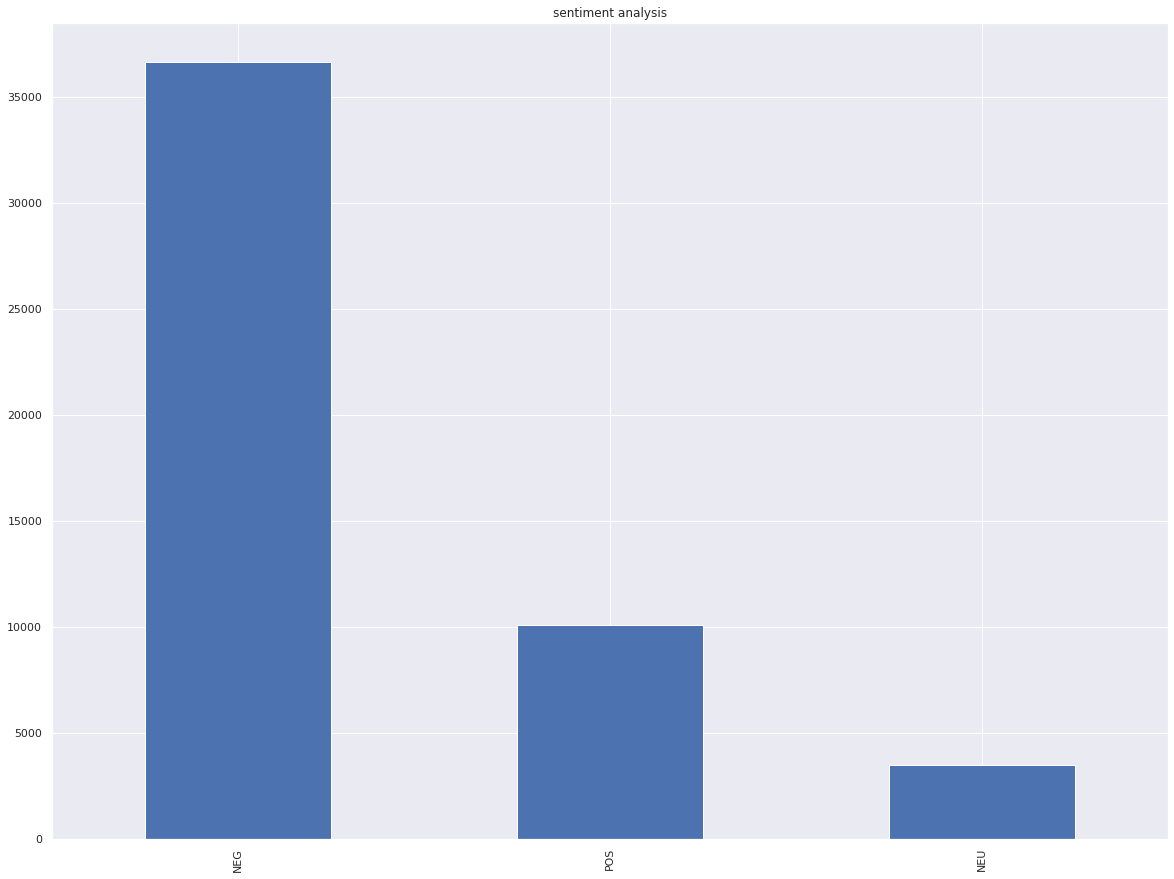

In [ ]:
plt.figure(figsize=(20, 15))
filtered_quotes.sent_type.value_counts().plot(kind='bar',title="sentiment analysis")

In [ ]:
sns.countplot(filtered_quotes.sent_type)
plt.xlabel('review score');

# Sentimental analysis with fine tuned Bert model on google play store review dataset (to be compared maybe with another model fine tuned on something different, imdb ones?) and get embeddings with BERT expert model.

### Setup

In [ ]:
!pip install importlib-metadata==4.4

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2


In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

In [ ]:
pip install transformers==2.8.0 #there was an incompatibility problem with more recent versions

In [ ]:
!nvidia-smi #check which GPU got assigned on Collab, trying to get one of the big boys :)

In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 63.1MB/s]


In [ ]:
df = pd.read_csv('reviews.csv')

In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


We have about 16k examples. Let's check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Great, no missing values in the score and review texts! Do we have class imbalance?

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


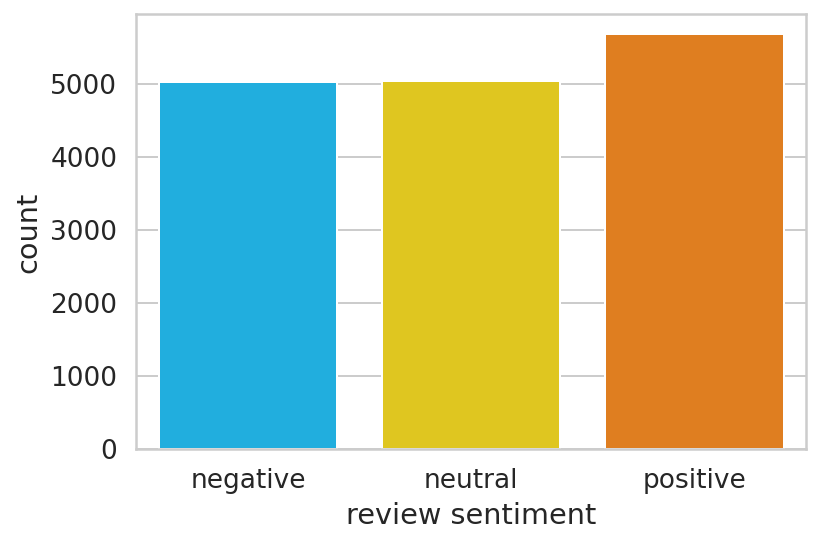

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

The balance was (mostly) restored.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


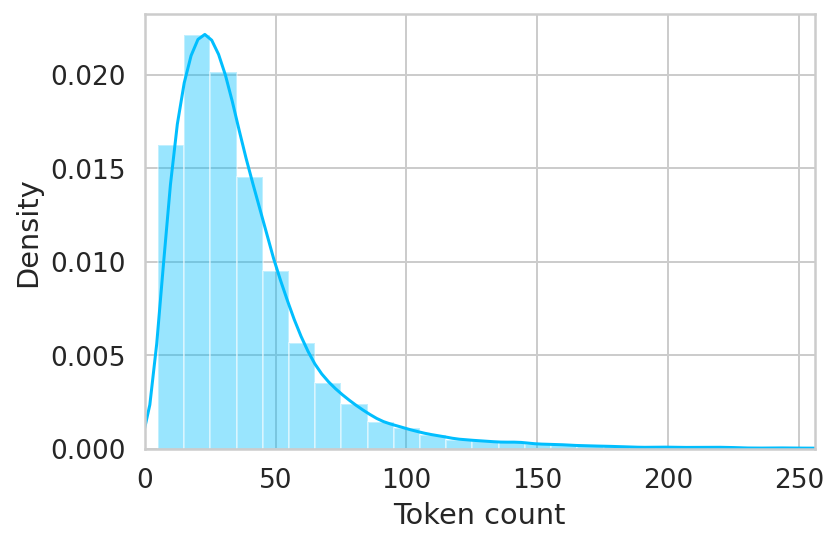

In [ ]:
sns.distplot(quotes['N_of_tokens'])
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
def b_tok(text):
  tokens = tokenizer.encode(text, max_length=512)
  return len(tokens)

In [ ]:
quotes['Tok_Bert'] = quotes['quotation'].apply(b_tok) #tokens from Bert tokenizers

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


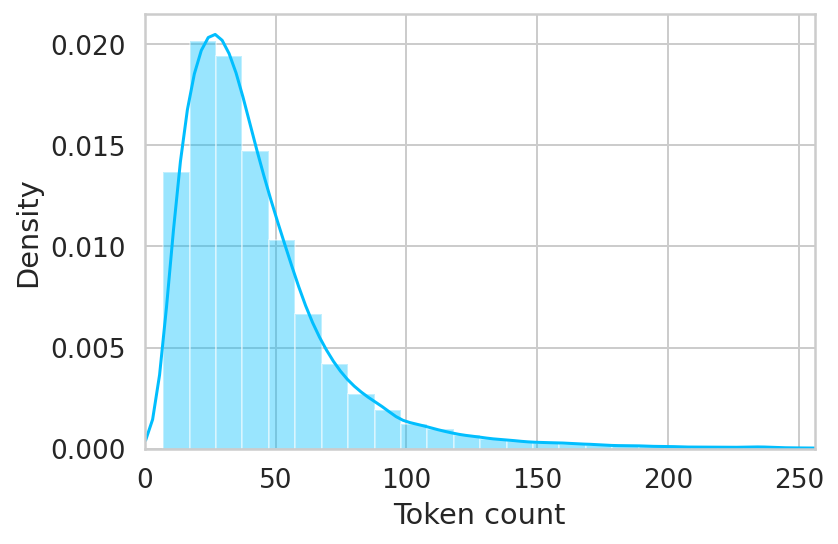

In [ ]:
sns.distplot(quotes['Tok_Bert'])
plt.xlim([0, 256]);
plt.xlabel('Token count');

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = []

for txt in df.quotation:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


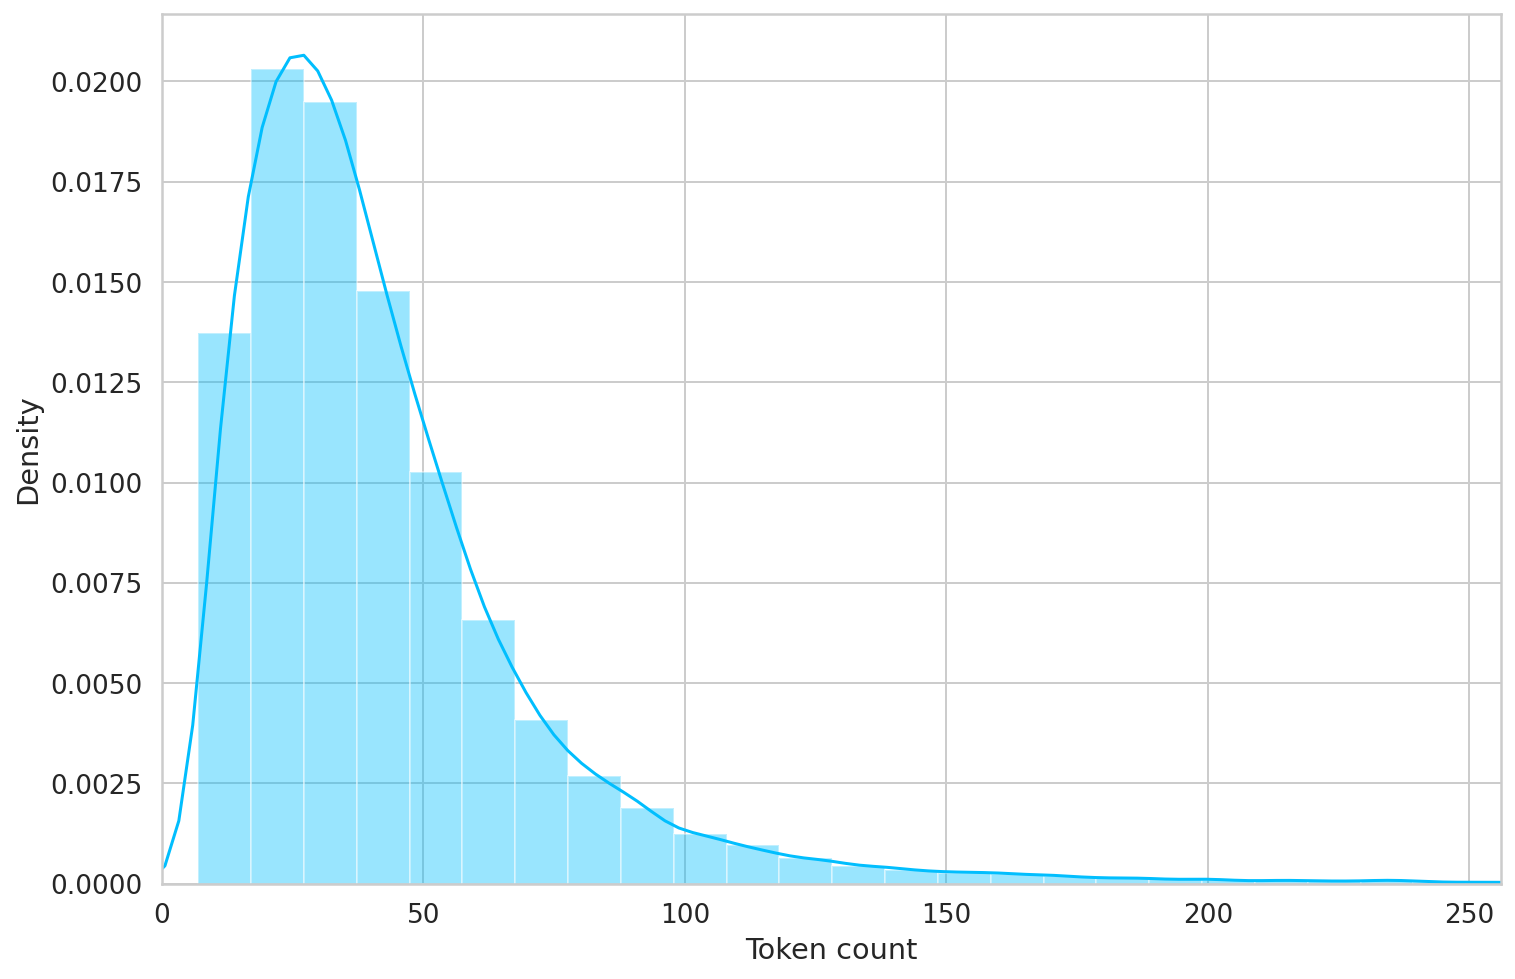

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 150 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 200

from here for the parts related to dataloader did the 

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
'''df_train.shape, df_val.shape, df_test.shape'''

((14171, 12), (787, 12), (788, 12))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [ ]:
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
#output[0].shape #last hidden state for last trasformers versione

torch.Size([1, 32, 768])

In [ ]:
quotes = quotes.query("Tok_Bert <= 200").reset_index(drop=True)

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
def bert_emb(text):
  print(torch.cuda.is_available())
  encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  _, pooled_output = bert_model(input_ids, attention_mask)
  torch.cuda.empty_cache()
  return pooled_output

In [ ]:
 quotes['Bert_embeddings'] = quotes['quotation'].apply(bert_emb)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


RuntimeError: ignored

In [ ]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape #these should be the embedding vectors 768 dimensionals

torch.Size([1, 768])



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = bert_model
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 200])
torch.Size([16, 200])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
model(input_ids, attention_mask)

(tensor([[[ 5.7945e-01,  1.9642e-01, -6.1045e-02,  ..., -3.3177e-01,
            2.0142e-01,  4.6892e-02],
          [ 1.0045e+00, -2.2568e-01,  5.4038e-01,  ...,  1.0020e-01,
            7.1539e-03,  2.3366e-01],
          [ 5.8510e-01,  1.1731e-01, -3.2286e-01,  ...,  1.9493e-01,
           -1.8682e-01,  3.6162e-01],
          ...,
          [ 6.0242e-01,  2.3778e-01,  6.5346e-04,  ...,  1.3414e-01,
           -4.7297e-01,  8.2183e-02],
          [ 2.5392e-01,  1.7197e-01, -1.8348e-02,  ..., -7.5631e-02,
           -3.9114e-01,  1.4257e-01],
          [ 2.1995e-01,  4.5674e-01, -9.0706e-02,  ..., -3.3515e-01,
           -3.5787e-01,  5.4092e-02]],
 
         [[ 6.3080e-01,  2.7756e-01,  5.2580e-02,  ..., -2.0669e-01,
            2.7321e-01,  1.4607e-01],
          [ 5.8938e-01, -3.6053e-01,  7.7591e-01,  ..., -1.2263e-01,
            2.6968e-01,  2.6261e-01],
          [-1.3139e-01,  1.4765e-01, -1.0714e-01,  ..., -1.7812e-02,
            3.0214e-01,  9.9286e-01],
          ...,
    

In [ ]:
!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Downloading...
From: https://drive.google.com/uc?id=1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
To: /content/best_model_state.bin
100% 433M/433M [00:09<00:00, 43.3MB/s]


### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7330631300571541 accuracy 0.6653729447463129
Val   loss 0.5767546480894089 accuracy 0.7776365946632783

Epoch 2/10
----------
Train loss 0.4158683338330777 accuracy 0.8420012701997036
Val   loss 0.5365073362737894 accuracy 0.832274459974587

Epoch 3/10
----------
Train loss 0.24015077009679367 accuracy 0.922023851527768
Val   loss 0.5074492372572422 accuracy 0.8716645489199493

Epoch 4/10
----------
Train loss 0.16012676668187295 accuracy 0.9546962105708843
Val   loss 0.6009970247745514 accuracy 0.8703939008894537

Epoch 5/10
----------
Train loss 0.11209654617575301 accuracy 0.9675393409074872
Val   loss 0.7367783848941326 accuracy 0.8742058449809403

Epoch 6/10
----------
Train loss 0.08572274737026433 accuracy 0.9764307388328276
Val   loss 0.7251267762482166 accuracy 0.8843710292249047

Epoch 7/10
----------
Train loss 0.06132202987342602 accuracy 0.9833462705525369
Val   loss 0.7083295831084251 accuracy 0.889453621346887

Epoch 8/10
----------
Tra

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

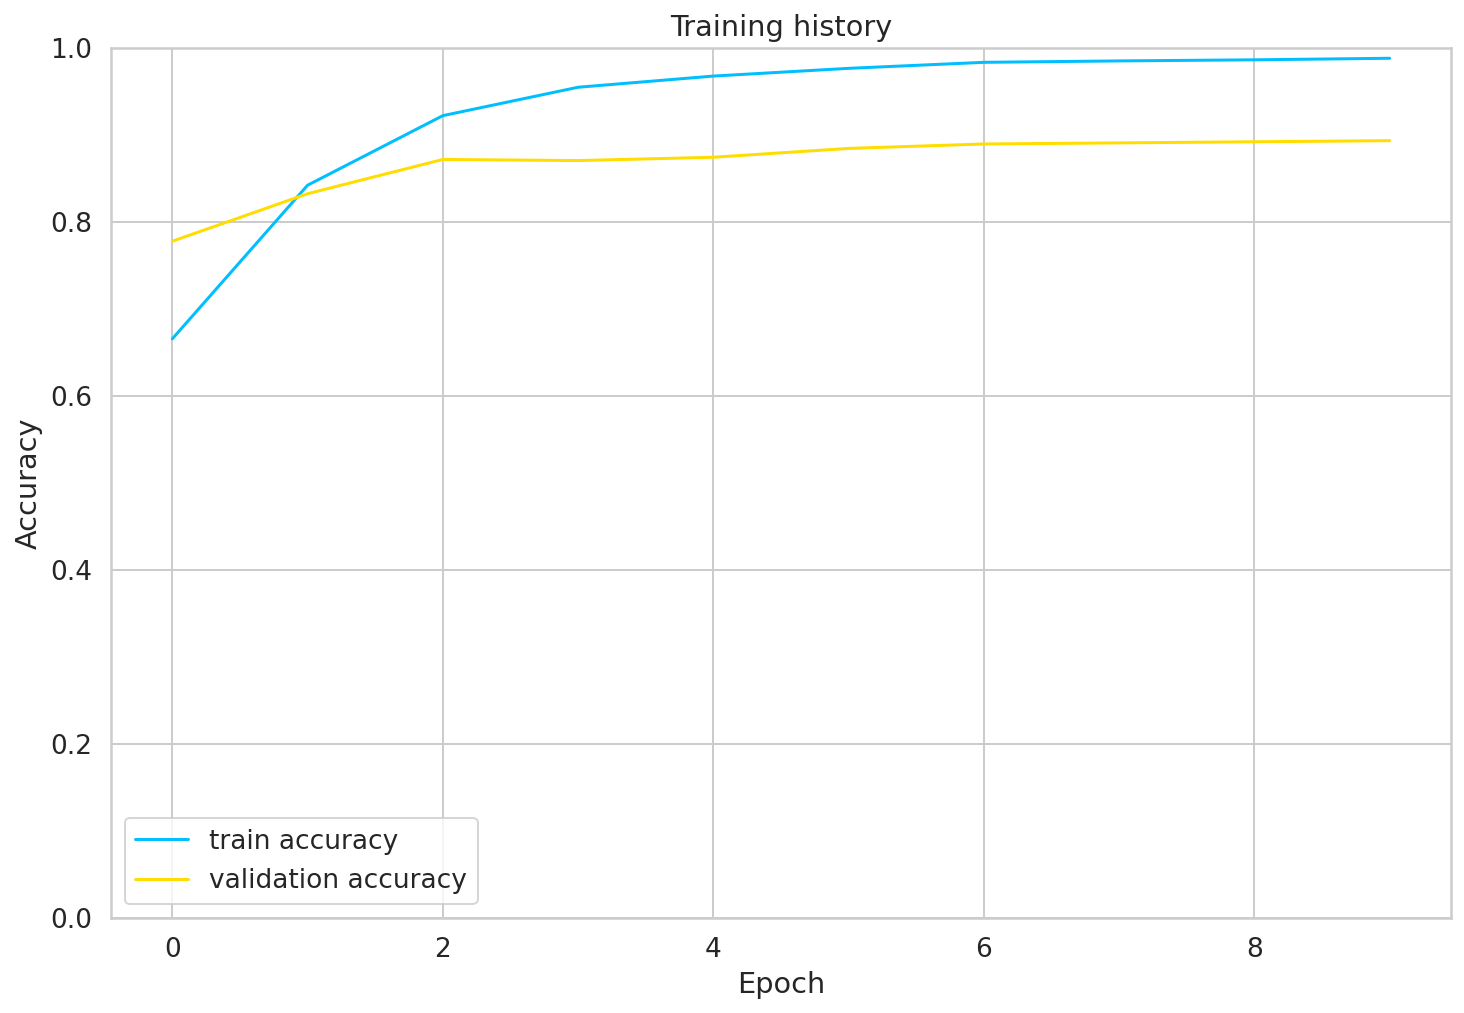

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

NameError: ignored

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       245
     neutral       0.83      0.85      0.84       254
    positive       0.92      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

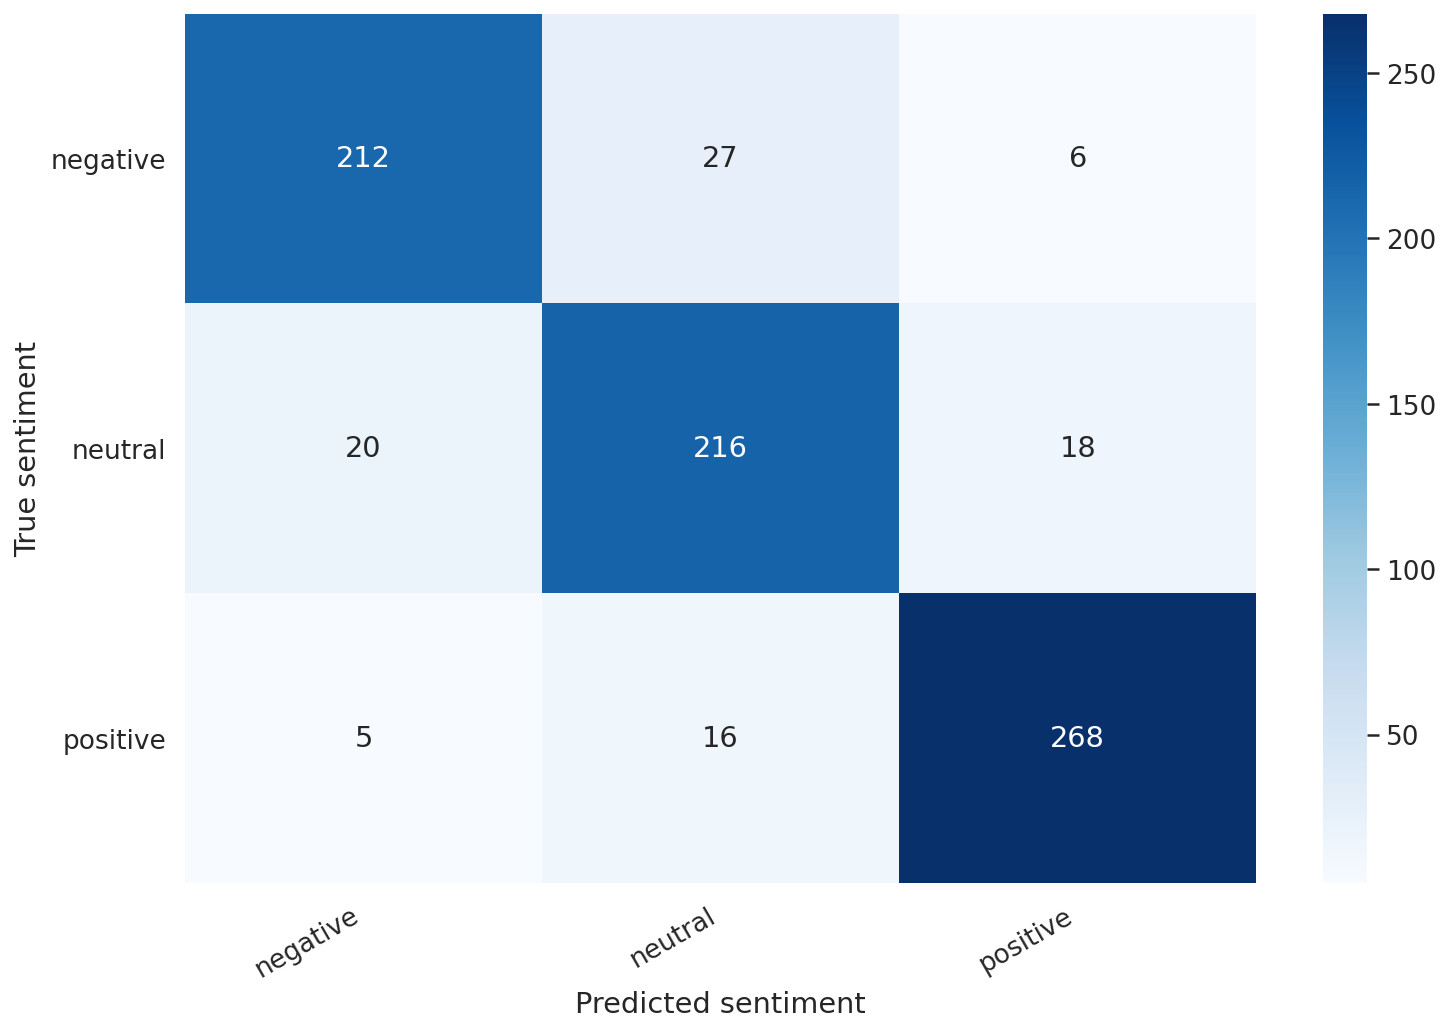

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

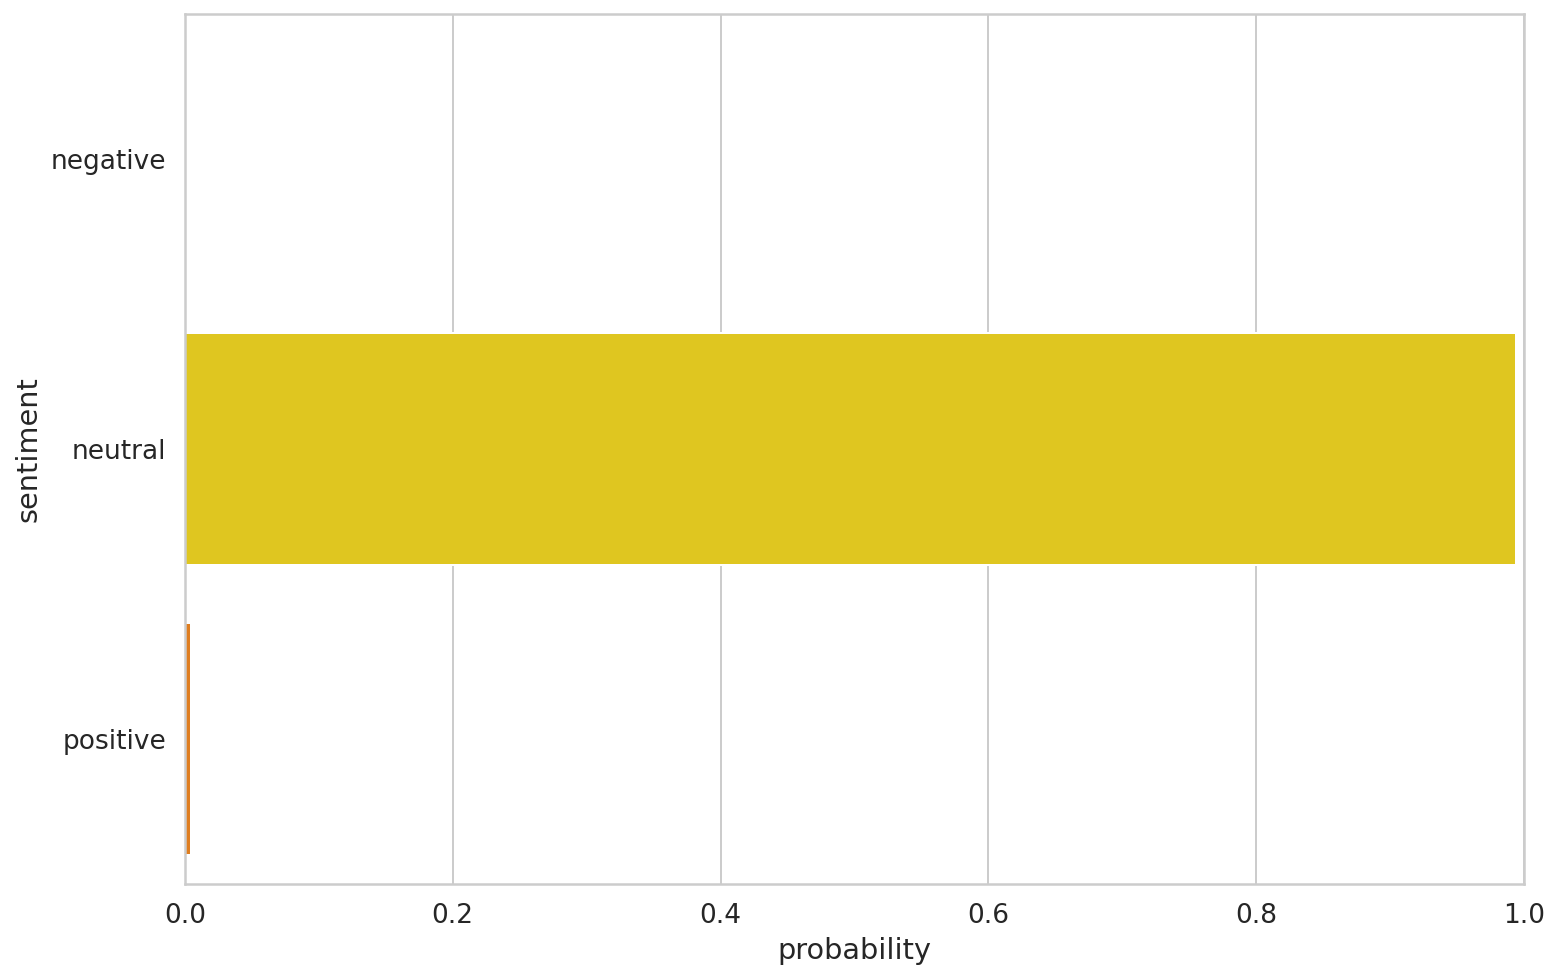

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "We want to make sure the city has the best laws in place for gun control"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
print(output.shape)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
#print(f'predictions: {prediction}')
#print(f'predictions: {prediction_probs}')


torch.Size([1, 3])
Review text: We want to make sure the city has the best laws in place for gun control
Sentiment  : positive


In [ ]:
def bert_sent(text):
  encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  return class_names[prediction]

In [ ]:
quotes['Bert_sentiment_type'] = quotes['quotation'].apply(bert_sent)

In [ ]:
quotes = quotes.drop(columns=['N of tokens'])

In [ ]:
quotes

,speaker,qids,date,quotation,keyword,scores,compound,sent_type,tokens,N_of_tokens,Bert_sentiment_type
0,President Obama,[Q76],2015-07-23,If you look at the number killed by gun violen...,gun violence,"{'neg': 0.213, 'neu': 0.733, 'pos': 0.054, 'co...",-0.8271,NEG,"[If, you, look, at, the, number, killed, by, g...",53,neutral
1,Donald Trump,"[Q22686, Q27947481]",2015-09-19,"scary sounding phrases like `assault weapons,'...",assault weapon,"{'neg': 0.561, 'neu': 0.344, 'pos': 0.095, 'co...",-0.9042,NEG,"[scary, sounding, phrases, like, `, assault, w...",25,negative
2,President Obama,[Q76],2015-12-02,It's still an active situation. FBI is on the ...,"mass shooting, firearm","{'neg': 0.059, 'neu': 0.85, 'pos': 0.091, 'com...",0.8902,POS,"[It, 's, still, an, active, situation, ., FBI,...",301,neutral
3,Ted Cruz,[Q2036942],2015-04-21,"So far, Ted Cruz, in my opinion would be best ...",gun owner,"{'neg': 0.114, 'neu': 0.714, 'pos': 0.171, 'co...",0.5256,POS,"[So, far, ,, Ted, Cruz, ,, in, my, opinion, wo...",40,neutral
4,Hillary Rodham Clinton,[Q6294],2015-10-25,"Stopping gun violence is worth fighting for, a...",gun violence,"{'neg': 0.505, 'neu': 0.286, 'pos': 0.21, 'com...",-0.7351,NEG,"[Stopping, gun, violence, is, worth, fighting,...",15,positive
...,...,...,...,...,...,...,...,...,...,...,...
50201,Scott Wiener,[Q7437504],2019-12-11,United Playaz gives me hope... hope that worki...,gun violence,"{'neg': 0.151, 'neu': 0.65, 'pos': 0.2, 'compo...",0.2732,POS,"[United, Playaz, gives, me, hope, ..., hope, t...",37,positive
50202,Richard Blumenthal,[Q2023708],2019-03-26,We've got to ask the questions of our friends ...,gun violence,"{'neg': 0.186, 'neu': 0.543, 'pos': 0.271, 'co...",0.4515,POS,"[We, 've, got, to, ask, the, questions, of, ou...",29,neutral
50203,Cory Booker,[Q1135767],2019-05-15,a 40% drop in gun homicides,gun homicide,"{'neg': 0.529, 'neu': 0.471, 'pos': 0.0, 'comp...",-0.5423,NEG,"[a, 40, %, drop, in, gun, homicides]",7,negative
50204,Eric Swalwell,[Q3466996],2019-02-04,After 6 yrs of working in Congress to end gun ...,gun violence,"{'neg': 0.397, 'neu': 0.48, 'pos': 0.122, 'com...",-0.7430,NEG,"[After, 6, yrs, of, working, in, Congress, to,...",17,negative


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Bert_sentiment_type')

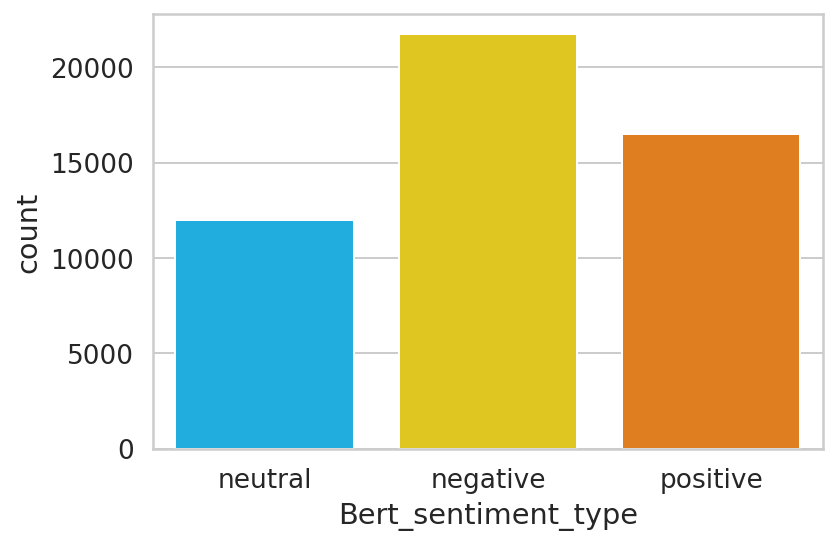

In [ ]:
ax = sns.countplot(quotes.Bert_sentiment_type)
plt.xlabel('Bert_sentiment_type')

In [ ]:
quotes.to_pickle('quotes_bert_tok.pkl')

Way more balanced! :)

###get embeddings vectors from bert expert model trained on book corpus, sst2 dataset and wiki (might not generalise well with more social media like so maybe consider removing quotes with problematic characters like @, WTF and others)

In [ ]:
!nvidia-smi

Tue Dec 14 17:44:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pandas==1.3.0

     |████████████████████████████████| 10.8 MB 10.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.0 which is incompatible.


In [ ]:
!pip3 install --quiet tensorflow
!pip3 install --quiet tensorflow_text

     |████████████████████████████████| 4.9 MB 7.8 MB/s 


In [ ]:
import pandas as pd
quotes = pd.read_pickle('/content/quotes_bert_tok.pkl')

In [ ]:
quotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45769 entries, 0 to 45768
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   speaker              45769 non-null  object        
 1   qids                 45769 non-null  object        
 2   date                 45769 non-null  datetime64[ns]
 3   quotation            45769 non-null  object        
 4   keyword              45769 non-null  object        
 5   scores               45769 non-null  object        
 6   compound             45769 non-null  float64       
 7   sent_type            45769 non-null  object        
 8   tokens               45769 non-null  object        
 9   N_of_tokens          45769 non-null  int64         
 10  Bert_sentiment_type  45769 non-null  object        
 11  Tok_Bert             45769 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 4.2+ MB


In [ ]:
import seaborn as sns
from sklearn.metrics import pairwise

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [ ]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## Sentences

Let's take some sentences from Wikipedia to run through model

## Run the model

We'll load the BERT model from TF-Hub, tokenize our sentences using the matching preprocessing model from TF-Hub, then feed in the tokenized sentences to the model. To keep this colab fast and simple, we recommend running on GPU.

Go to **Runtime** → **Change runtime type** to make sure that **GPU** is selected

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
preprocess = hub.load(PREPROCESS_MODEL)

In [ ]:
bert = hub.load(BERT_MODEL)

In [ ]:
'''quotes = quotes.query("N_of_tokens <= 160").reset_index(drop=True)'''

'quotes = quotes.query("N_of_tokens <= 160").reset_index(drop=True)'

In [ ]:
'''index = quotes.query("keyword == 'handguns'")
for i in range(20):
  print(index.iloc[i,3])
  print('/n')'''

'index = quotes.query("keyword == \'handguns\'")\nfor i in range(20):\n  print(index.iloc[i,3])\n  print(\'/n\')'

In [ ]:
'''quotes = quotes.query("keyword != 'handguns'").reset_index(drop=True)'''

'quotes = quotes.query("keyword != \'handguns\'").reset_index(drop=True)'

In [ ]:
'''quotes = quotes.query("keyword != 'assault weapon'").reset_index(drop=True)'''

'quotes = quotes.query("keyword != \'assault weapon\'").reset_index(drop=True)'

In [ ]:
'''index = quotes.query("keyword == 'assault weapon'")
for i in range(20):
  print(index.iloc[i,3])
  print('/n')'''

'index = quotes.query("keyword == \'assault weapon\'")\nfor i in range(20):\n  print(index.iloc[i,3])\n  print(\'/n\')'

In [ ]:
'''index = quotes.query("keyword == 'concealed carry'")
for i in range(20):
  print(index.iloc[i,3])
  print('/n')'''

'index = quotes.query("keyword == \'concealed carry\'")\nfor i in range(20):\n  print(index.iloc[i,3])\n  print(\'/n\')'

In [ ]:
'''quotes.query("N_of_tokens <= 10") #consider removing at the end after having used bert'''

'quotes.query("N_of_tokens <= 10") #consider removing at the end after having used bert'

In [ ]:
!nvidia-smi -L  

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-33bec752-ebc5-8f42-3910-13a3db31cd3c)


In [ ]:
from more_itertools import sliced

In [ ]:
for chunk in sliced(quotes, 2000):
  print(chunk.shape)

(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(2000, 12)
(1769, 12)


In [ ]:
Chunk = 2000
i = 0
for chunk in sliced(quotes, Chunk):
  if i==0:
    d1 = chunk.copy(deep=True)
  elif i==1:
    d2 = chunk.copy(deep=True)
  elif i==2:
    d3 = chunk.copy(deep=True)
  elif i==3:
    d4 = chunk.copy(deep=True)
  elif i==4:
    d5 = chunk.copy(deep=True)
  elif i==5:
    d6 = chunk.copy(deep=True)
  elif i==6:
    d7 = chunk.copy(deep=True)
  elif i==7:
    d8 = chunk.copy(deep=True)
  elif i==8:
    d9 = chunk.copy(deep=True)
  elif i==9:
    d10 = chunk.copy(deep=True)
  elif i==10:
    d11 = chunk.copy(deep=True)
  elif i==11:
    d12 = chunk.copy(deep=True)
  elif i==12:
    d13 = chunk.copy(deep=True)
  elif i==13:
    d14 = chunk.copy(deep=True)
  elif i==14:
    d15 = chunk.copy(deep=True)
  elif i==15:
    d16 = chunk.copy(deep=True)
  elif i==16:
    d17 = chunk.copy(deep=True)
  elif i==17:
    d18 = chunk.copy(deep=True)
  elif i==18:
    d19 = chunk.copy(deep=True)
  elif i==19:
    d20 = chunk.copy(deep=True)
  elif i==20:
    d21 = chunk.copy(deep=True)
  elif i==21:
    d22 = chunk.copy(deep=True)
  elif i==22:
    d23 = chunk.copy(deep=True)   
  i += 1

In [ ]:
d23.shape

(1769, 12)

In [ ]:
def bert_emb(text):
  text = [text]
  inputs = preprocess(text)
  outputs = bert(inputs)
  return outputs["pooled_output"]

In [ ]:
#d1['Bert_embeddings'] = d1['quotation'].apply(bert_emb)
#print('1')
#d2['Bert_embeddings'] = d2['quotation'].apply(bert_emb)
#print('2')
#d3['Bert_embeddings'] = d3['quotation'].apply(bert_emb)
#print('3')
#d4['Bert_embeddings'] = d4['quotation'].apply(bert_emb)
#print('4')
#d5['Bert_embeddings'] = d5['quotation'].apply(bert_emb)
#print('5')
#d6['Bert_embeddings'] = d6['quotation'].apply(bert_emb)
#print('6')
#d7['Bert_embeddings'] = d7['quotation'].apply(bert_emb)
#print('7')
#d8['Bert_embeddings'] = d8['quotation'].apply(bert_emb)
#print('8')
#d9['Bert_embeddings'] = d9['quotation'].apply(bert_emb)
#d10['Bert_embeddings'] = d10['quotation'].apply(bert_emb)
#print('10')
#d11['Bert_embeddings'] = d11['quotation'].apply(bert_emb)
#d12['Bert_embeddings'] = d12['quotation'].apply(bert_emb)
#print('12')
#d13['Bert_embeddings'] = d13['quotation'].apply(bert_emb)
#d14['Bert_embeddings'] = d14['quotation'].apply(bert_emb)
#print('14')
#d15['Bert_embeddings'] = d15['quotation'].apply(bert_emb)
#d16['Bert_embeddings'] = d16['quotation'].apply(bert_emb)
#print('16')
#d17['Bert_embeddings'] = d17['quotation'].apply(bert_emb)
#d18['Bert_embeddings'] = d18['quotation'].apply(bert_emb)
#print('18')
#d19['Bert_embeddings'] = d19['quotation'].apply(bert_emb)
#d20['Bert_embeddings'] = d20['quotation'].apply(bert_emb)
#print('20')
#d21['Bert_embeddings'] = d21['quotation'].apply(bert_emb)
#d22['Bert_embeddings'] = d22['quotation'].apply(bert_emb)
#print('22')
d23['Bert_embeddings'] = d23['quotation'].apply(bert_emb)

In [ ]:
d23.to_pickle('d23.pkl')

In [ ]:
#d22.to_pickle('d22.pkl')

## Semantic similarity

Now let's take a look at the `pooled_output` embeddings of our sentences and compare how similar they are across sentences.

In [ ]:
#@title Helper functions

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = pairwise.cosine_similarity(features)
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, cmap="Blues", cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

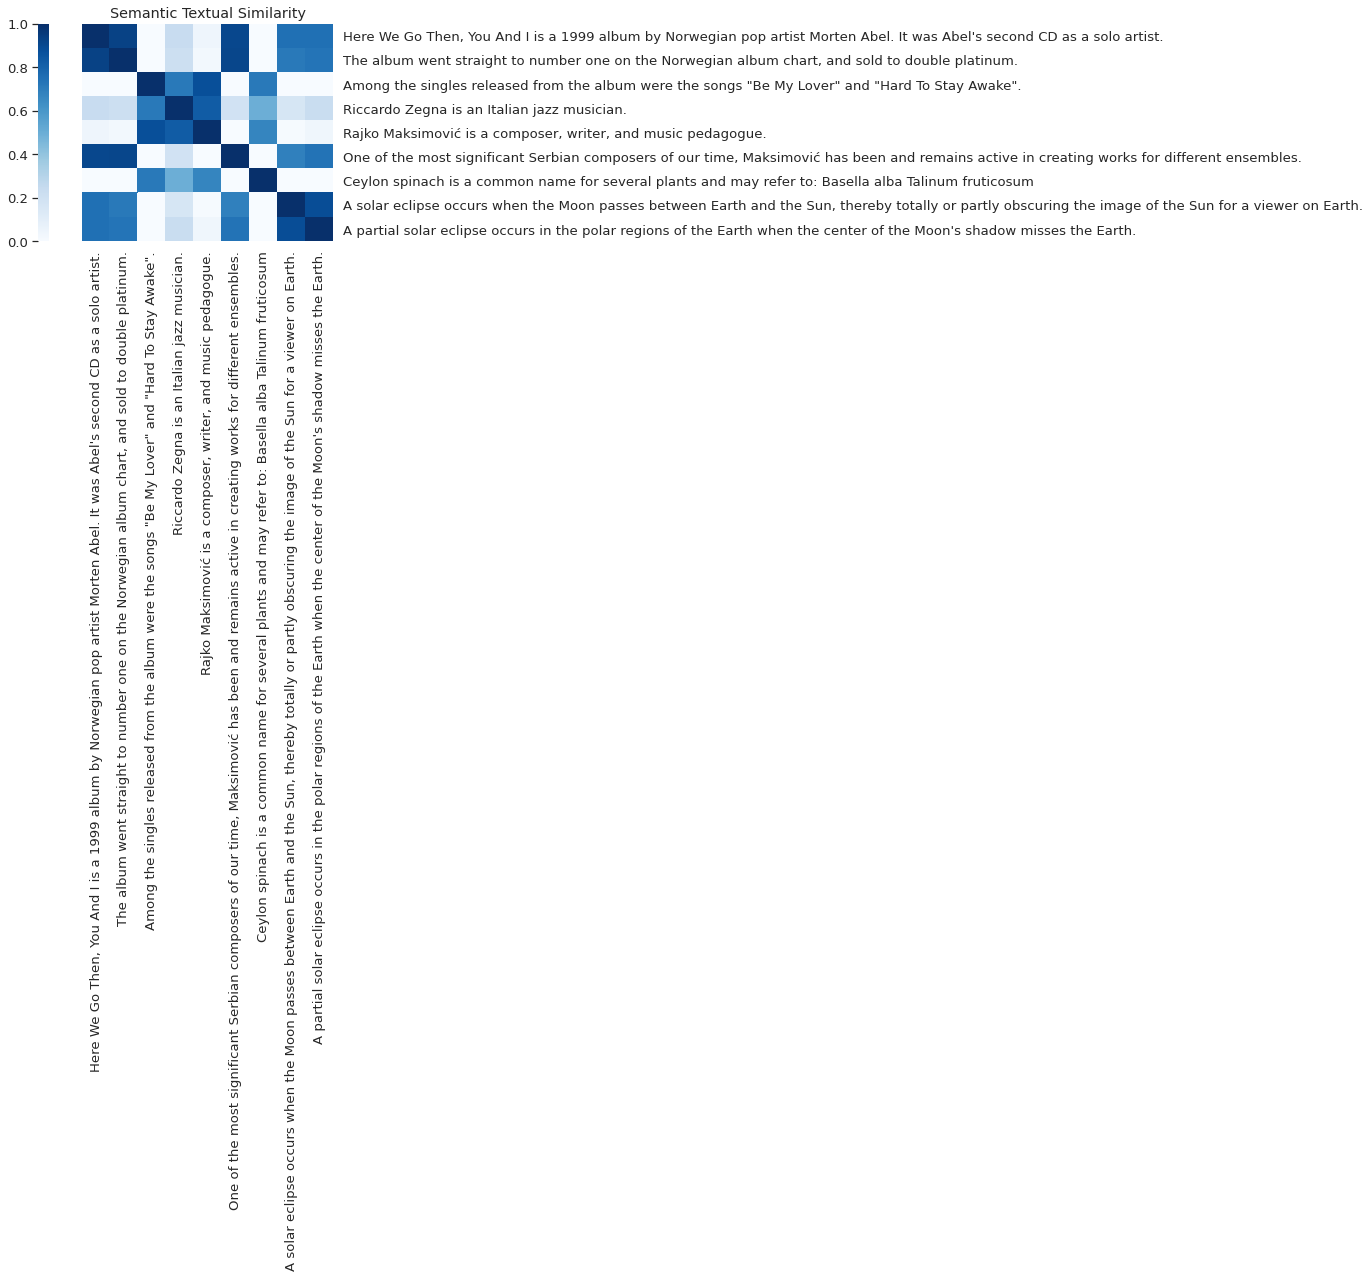

In [ ]:
plot_similarity(outputs["pooled_output"], sentences)

# Just load this dataframe finalized with all the BERT stuff included for final analysis

In [ ]:
final_quotes= read_pickle('....pkl')

# Gunshot dataset massaging

In [ ]:
DATA_FOLDER = '/content/drive/MyDrive/datasets_ADA/gunshot/'

MASS_SHOOTINGS_15 = DATA_FOLDER+"massshootings15.csv"
MASS_SHOOTINGS_16 = DATA_FOLDER+"massshootings16.csv"
MASS_SHOOTINGS_17 = DATA_FOLDER+"massshootings17.csv"
MASS_SHOOTINGS_18 = DATA_FOLDER+"massshootings18.csv"
MASS_SHOOTINGS_19 = DATA_FOLDER+"massshootings19.csv"
ACCIDENTS = DATA_FOLDER+"accidents.csv"

In [ ]:
mass_shootings_15 = pd.read_csv(MASS_SHOOTINGS_15)
mass_shootings_16 = pd.read_csv(MASS_SHOOTINGS_16)
mass_shootings_17 = pd.read_csv(MASS_SHOOTINGS_17)
mass_shootings_18 = pd.read_csv(MASS_SHOOTINGS_18)
mass_shootings_19 = pd.read_csv(MASS_SHOOTINGS_19)
accidents = pd.read_csv(ACCIDENTS)

In [ ]:
mass_shootings=pd.concat([mass_shootings_15, mass_shootings_16, mass_shootings_17, mass_shootings_18,
                          mass_shootings_19], ignore_index=True)

In [ ]:
mass_shootings = mass_shootings.drop(columns=['State', 'City Or County', 'Address', 'Operations'])
mass_shootings['Category']='Mass Shooting'
mass_shootings['Incident Date'] = pd.to_datetime(mass_shootings['Incident Date'])
accidents = accidents.drop(columns=['State', 'City Or County', 'Address', 'Operations'])
accidents = accidents[~accidents['Incident Date'].str.contains("2021")]
accidents = accidents[~accidents['Incident Date'].str.contains("2020")]
accidents['Category']='Accident'
accidents['Incident Date'] = pd.to_datetime(accidents['Incident Date'])

In [ ]:
mass_shootings.sort_values('# Killed', ascending=False).head()

,Incident ID,Incident Date,# Killed,# Injured,Category
788,946496,2017-10-01,59,441,Mass Shooting
581,577157,2016-06-12,50,53,Mass Shooting
754,980577,2017-11-05,27,20,Mass Shooting
1574,1466705,2019-08-03,23,23,Mass Shooting
1372,1049217,2018-02-14,17,17,Mass Shooting


In [ ]:
accidents.sort_values('# Killed', ascending=False).head()

,Incident ID,Incident Date,# Killed,# Injured,Category
1058,1564937,2019-12-05,4,1,Accident
1400,1323697,2019-02-09,2,0,Accident
1985,926038,2017-09-02,2,0,Accident
1825,1031159,2018-01-19,2,0,Accident
1445,1289271,2018-12-31,2,0,Accident


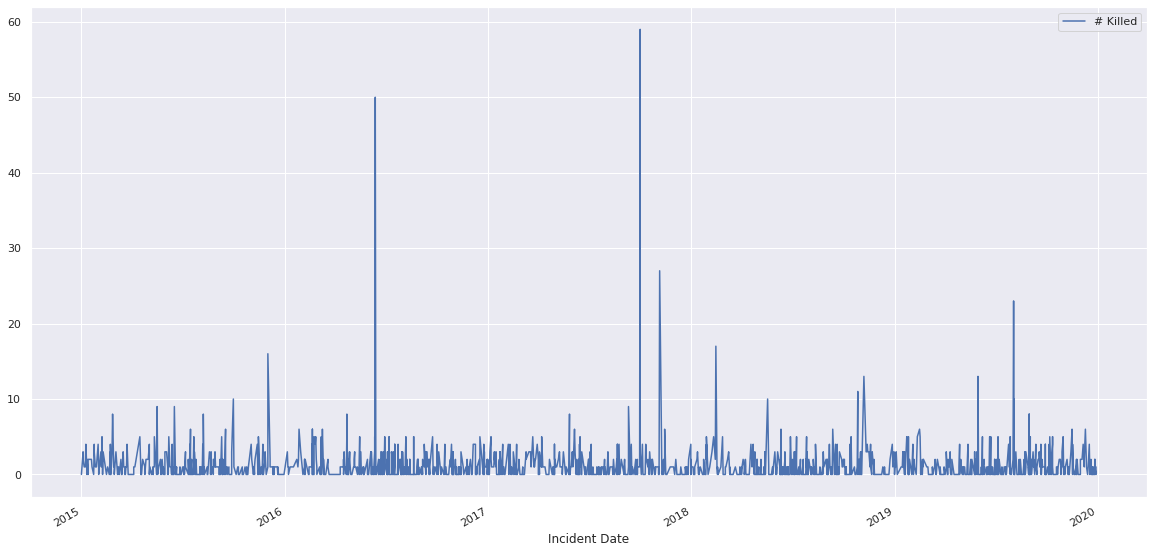

In [ ]:
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10));

# Final analysis comparing/integrating results from quotes dataset and gunshot

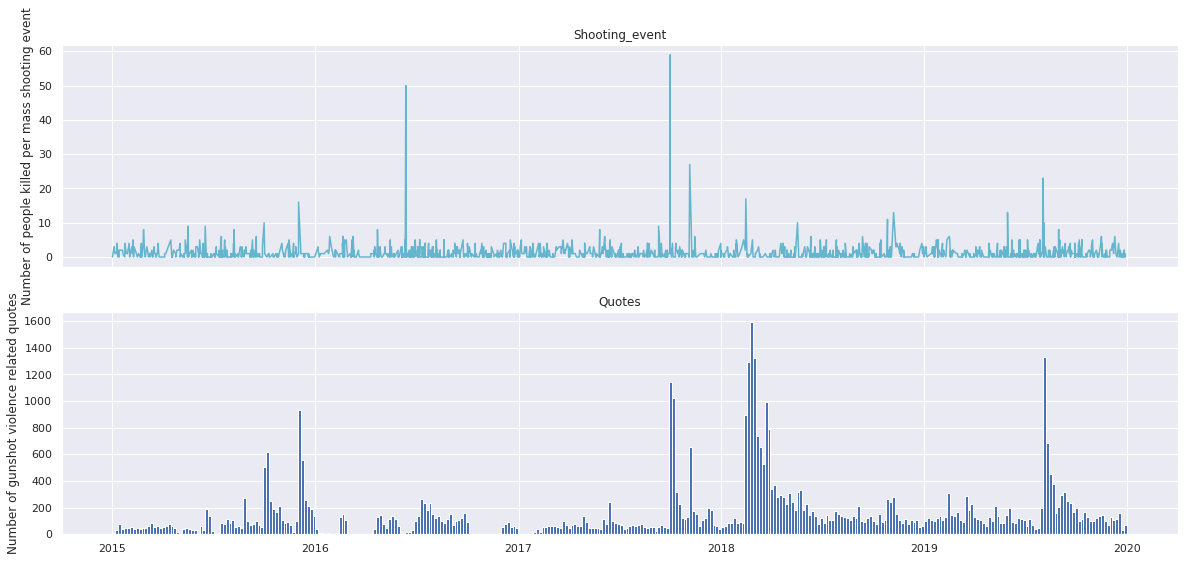

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
all_attr_quotes['date'].hist(figsize=(20,10), bins = 350, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

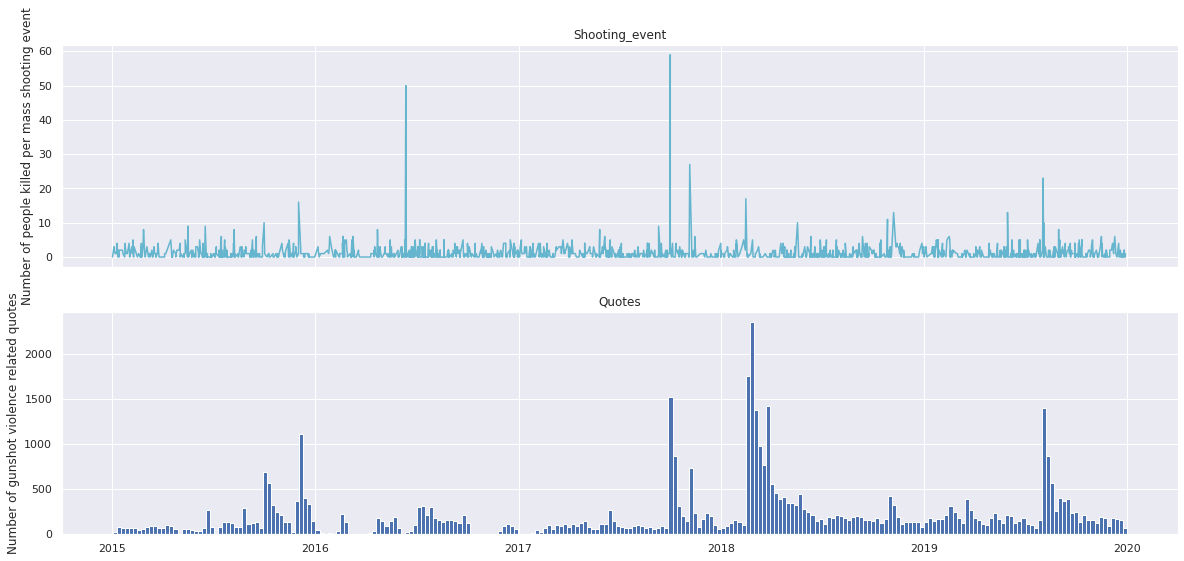

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
all_attr_quotes['date'].hist(figsize=(20,10), bins = 250, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

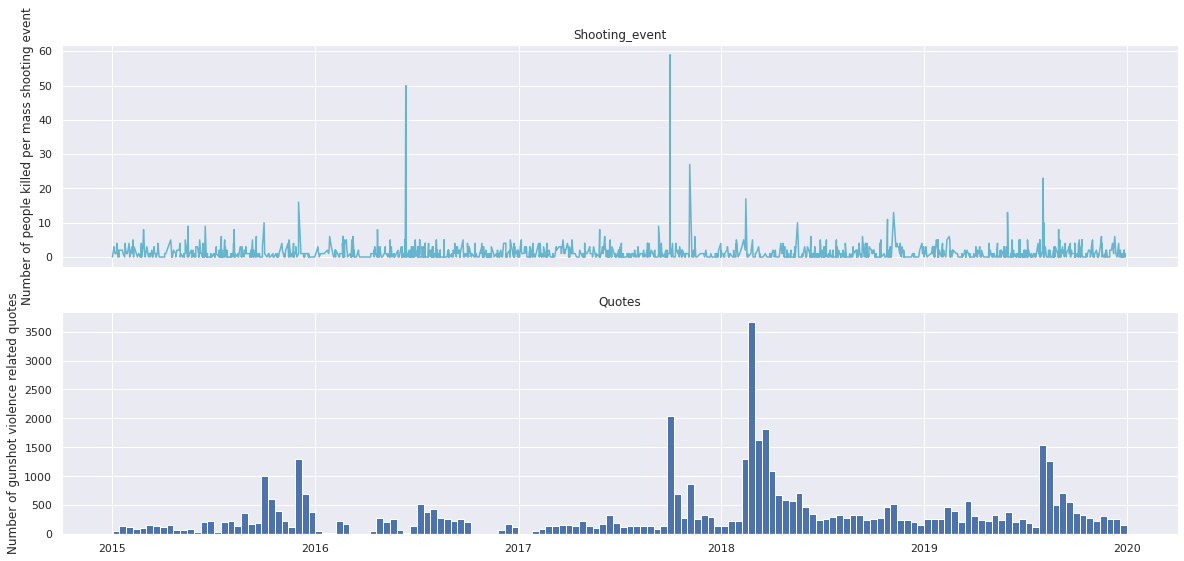

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
all_attr_quotes['date'].hist(figsize=(20,10), bins = 150, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

In [ ]:
all_attr_quotes['date'] = all_attr_quotes.date.dt.date #put data into 

In [ ]:
gg = mass_shootings.groupby('Incident Date').sum()['# Killed'].to_frame(name = 'N Killed').reset_index()

In [ ]:
pp = all_attr_quotes.groupby('date').mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

In [ ]:
pp

,date,Avg compound score par day
0,2015-01-01,-0.503150
1,2015-01-02,-0.725100
2,2015-01-04,-0.917800
3,2015-01-05,-0.104700
4,2015-01-06,0.292800
...,...,...
1679,2019-12-27,-0.232843
1680,2019-12-28,-0.189200
1681,2019-12-29,-0.428443
1682,2019-12-30,-0.337614


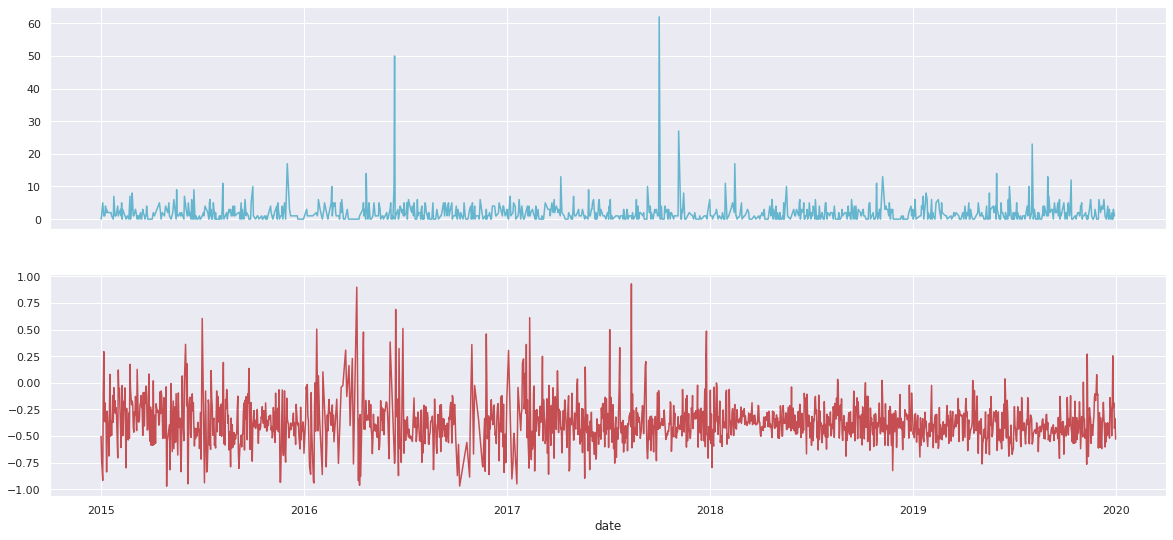

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(40, 15)
gg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
pp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

averagibg over one day as one might have expected creates a lot of noise.

In [ ]:
mass_shootings['Incident Date'] = pd.to_datetime(mass_shootings['Incident Date'])

In [ ]:
ggg = mass_shootings.groupby(pd.Grouper(key='Incident Date', axis=0, freq='5D', sort=True)).sum()['# Killed'].to_frame(name = 'N Killed').reset_index()

In [ ]:
all_attr_quotes['date'] = pd.to_datetime(all_attr_quotes['date'])

In [ ]:
all_attr_quotes.groupby(pd.Grouper(key='date', axis=0, freq='5D', sort=True))

In [ ]:
ppp = all_attr_quotes.groupby(pd.Grouper(key='date', axis=0, freq='5D', sort=True)).mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

In [ ]:
ppp

,date,Avg compound score par day
0,2015-01-01,-0.492709
1,2015-01-06,-0.281861
2,2015-01-11,-0.486345
3,2015-01-16,-0.365848
4,2015-01-21,-0.251942
...,...,...
361,2019-12-11,-0.469989
362,2019-12-16,-0.466920
363,2019-12-21,-0.255396
364,2019-12-26,-0.280169


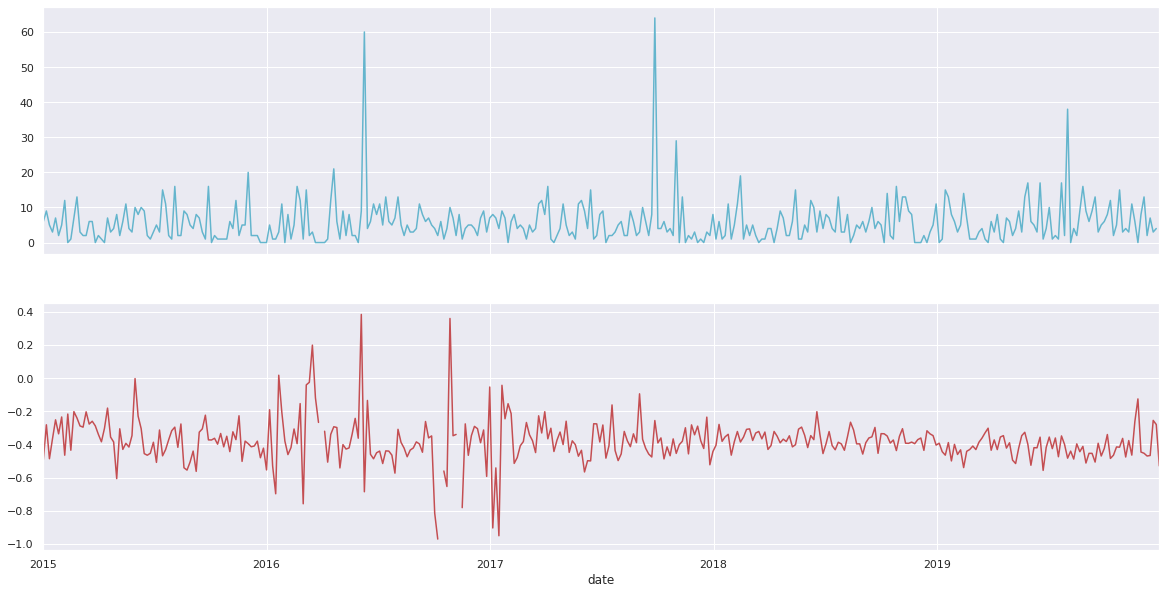

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True) #sum of deaths every 5 days and avg of 
fig.set_size_inches(40, 15)
ggg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
ppp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

In [ ]:
mass_shootings[mass_shootings['# Killed'] > 3] #142

,Incident ID,Incident Date,# Killed,# Injured,Category
18,456893,2015-12-02,16,19,Mass Shooting
24,452007,2015-11-23,4,1,Mass Shooting
36,448419,2015-11-15,5,0,Mass Shooting
39,446996,2015-11-13,4,1,Mass Shooting
46,440743,2015-11-02,4,0,Mass Shooting
...,...,...,...,...,...
1789,1320286,2019-02-03,4,0,Mass Shooting
1794,1312284,2019-01-26,5,0,Mass Shooting
1797,1310775,2019-01-24,4,1,Mass Shooting
1798,1310397,2019-01-24,4,1,Mass Shooting


In [ ]:
mass_shootings[mass_shootings['# Killed'] > 4]

,Incident ID,Incident Date,# Killed,# Injured,Category
18,456893,2015-12-02,16,19,Mass Shooting
36,448419,2015-11-15,5,0,Mass Shooting
66,423223,2015-10-01,10,9,Mass Shooting
83,418318,2015-09-17,6,0,Mass Shooting
92,412040,2015-09-10,5,0,Mass Shooting
...,...,...,...,...,...
1780,1328562,2019-02-16,5,0,Mass Shooting
1781,1327321,2019-02-15,6,6,Mass Shooting
1782,1324279,2019-02-11,5,0,Mass Shooting
1794,1312284,2019-01-26,5,0,Mass Shooting


In [ ]:
filt_min_4_deats=mass_shootings[mass_shootings['# Killed'] > 4] #about 1/4 of total dataset -> 248

In [ ]:
filt_min_4_deats

,Incident ID,Incident Date,# Killed,# Injured,Category
18,456893,2015-12-02,16,19,Mass Shooting
36,448419,2015-11-15,5,0,Mass Shooting
66,423223,2015-10-01,10,9,Mass Shooting
83,418318,2015-09-17,6,0,Mass Shooting
92,412040,2015-09-10,5,0,Mass Shooting
...,...,...,...,...,...
1780,1328562,2019-02-16,5,0,Mass Shooting
1781,1327321,2019-02-15,6,6,Mass Shooting
1782,1324279,2019-02-11,5,0,Mass Shooting
1794,1312284,2019-01-26,5,0,Mass Shooting


In [ ]:
ggg = filt_min_4_deats.groupby(pd.Grouper(key='Incident Date', axis=0, freq='10D', sort=True)).sum()['# Killed'].to_frame(name = 'N Killed').reset_index()
ppp = all_attr_quotes.groupby(pd.Grouper(key='date', axis=0, freq='10D', sort=True)).mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

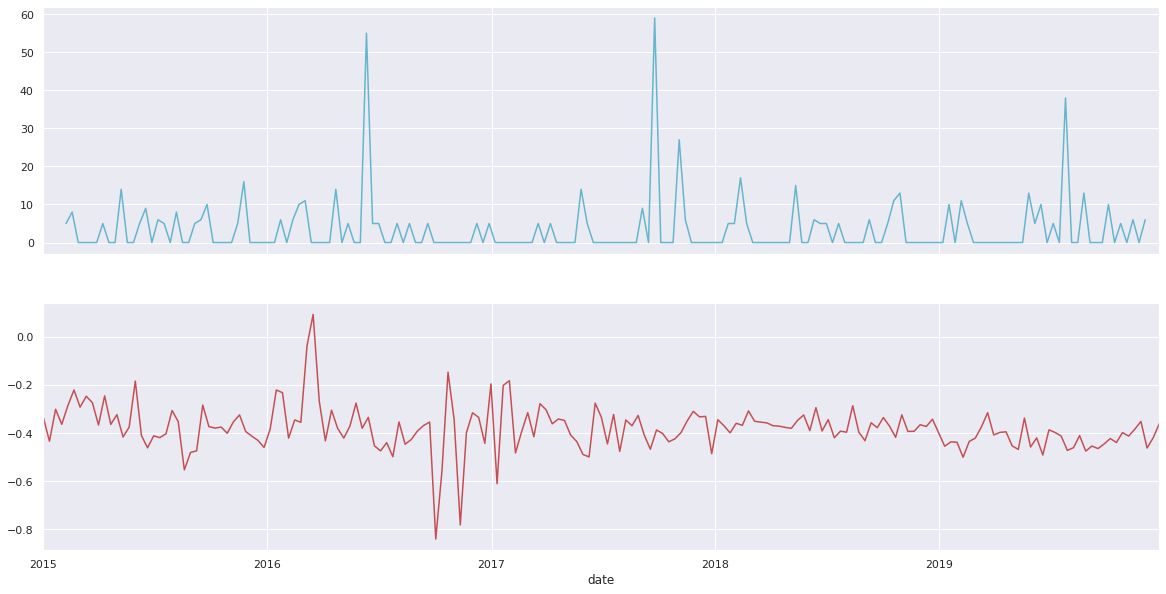

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True) #sum of deaths every 10 days and avg of sentiment for quotes over same time period
fig.set_size_inches(40, 15)
ggg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
ppp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

In [ ]:
all_attr_quotes.to_pickle('quotes_no_firearmo_no_unkown_speakers_with_sent_scores.pkl')

In [ ]:
all_attr_quotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50206 entries, 0 to 50205
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   speaker      50206 non-null  object        
 1   qids         50206 non-null  object        
 2   date         50206 non-null  datetime64[ns]
 3   quotation    50206 non-null  object        
 4   keyword      50206 non-null  object        
 5   scores       50206 non-null  object        
 6   compound     50206 non-null  float64       
 7   sent_type    50206 non-null  object        
 8   tokens       50206 non-null  object        
 9   N of tokens  50206 non-null  int64         
 10  N_of_tokens  50206 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 4.2+ MB


In [ ]:
ggg = mass_shootings.groupby(pd.Grouper(key='Incident Date', axis=0, freq='10D', sort=True)).sum()['# Killed'].to_frame(name = 'N Killed').reset_index()
ppp = all_attr_quotes.groupby(pd.Grouper(key='date', axis=0, freq='10D', sort=True)).mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

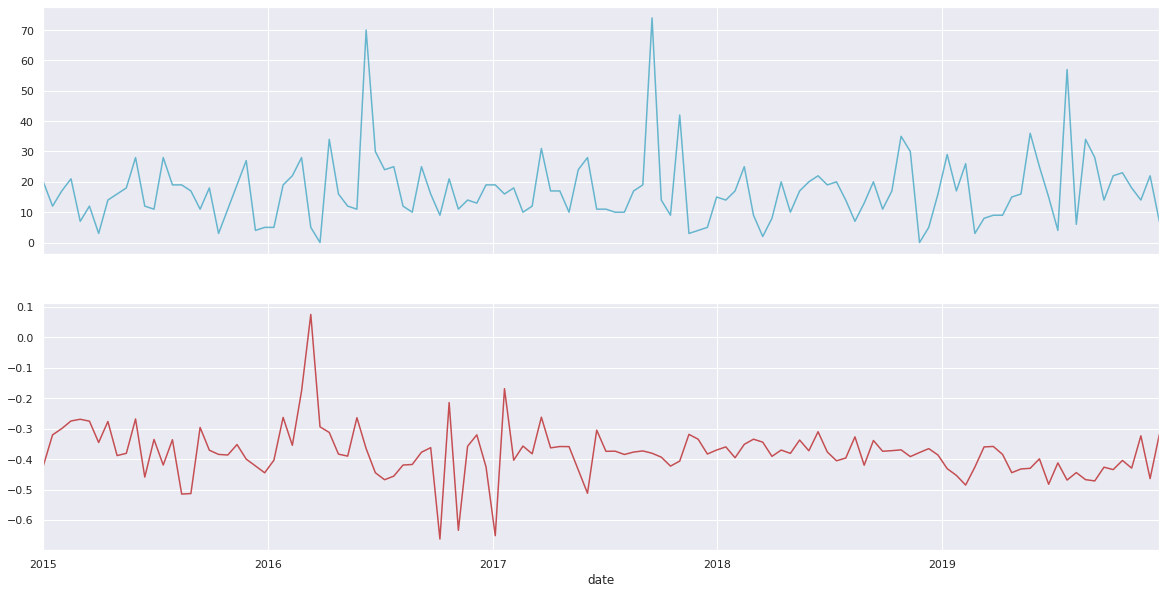

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True) #sum of deaths every 10 days and avg of sentiment for quotes over same time period
fig.set_size_inches(40, 15)
ggg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
ppp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

To remove noise either filter gunshot events lesser than a certain treshold of deaths or just normalize (like how much more or less than moving average

In [ ]:
ggg = mass_shootings.groupby(pd.Grouper(key='Incident Date', axis=0, freq='15D', sort=True)).sum()['# Killed'].to_frame(name = 'N Killed').reset_index()
ppp = all_attr_quotes.groupby(pd.Grouper(key='date', axis=0, freq='15D', sort=True)).mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

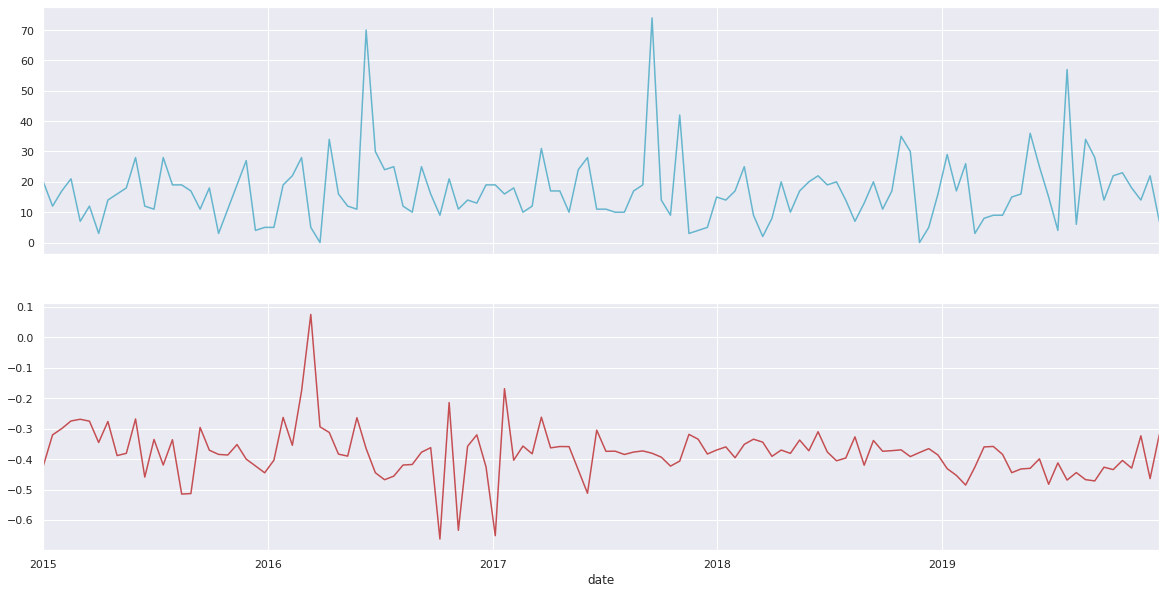

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True) #sum of deaths every 15 days and avg of sentiment for quotes over same time period
fig.set_size_inches(40, 15)
ggg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
ppp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

#### og data

In [ ]:
new_df['date'] = new_df.date.dt.date #new df is the quotes dataset, just created a new one to not mess with th old one

In [ ]:
gg = mass_shootings.groupby('Incident Date').sum()['# Killed'].to_frame(name = 'N Killed').reset_index()

In [ ]:
pp = new_df.groupby('date').mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

In [ ]:
pp

,date,Avg compound score par day
0,2015-01-01,-0.194931
1,2015-01-02,-0.402017
2,2015-01-03,-0.038957
3,2015-01-04,0.084733
4,2015-01-05,-0.267843
...,...,...
1739,2019-12-27,-0.198142
1740,2019-12-28,-0.225592
1741,2019-12-29,-0.389812
1742,2019-12-30,-0.294227


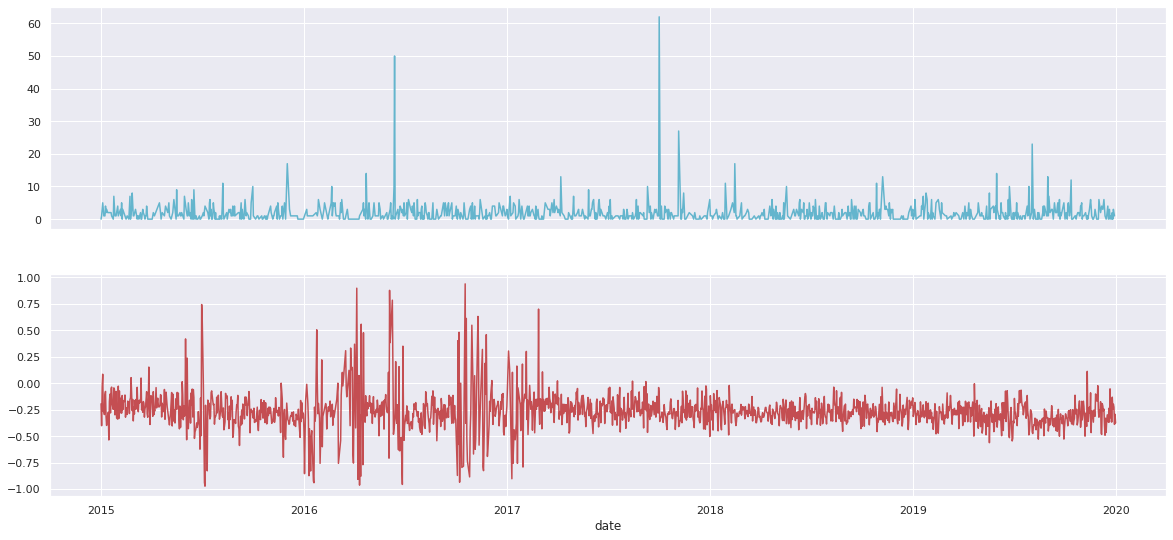

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(40, 15)
gg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
pp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

In [ ]:
new_df['date'] = pd.to_datetime(new_df['date'])

In [ ]:
new_df.groupby(pd.Grouper(key='date', axis=0, freq='5D', sort=True))

In [ ]:
ppp = new_df.groupby(pd.Grouper(key='date', axis=0, freq='5D', sort=True)).mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

In [ ]:
ppp

,date,Avg compound score par day
0,2015-01-01,-0.232570
1,2015-01-06,-0.194226
2,2015-01-11,-0.374308
3,2015-01-16,-0.120696
4,2015-01-21,-0.188879
...,...,...
361,2019-12-11,-0.408523
362,2019-12-16,-0.312460
363,2019-12-21,-0.172216
364,2019-12-26,-0.271008


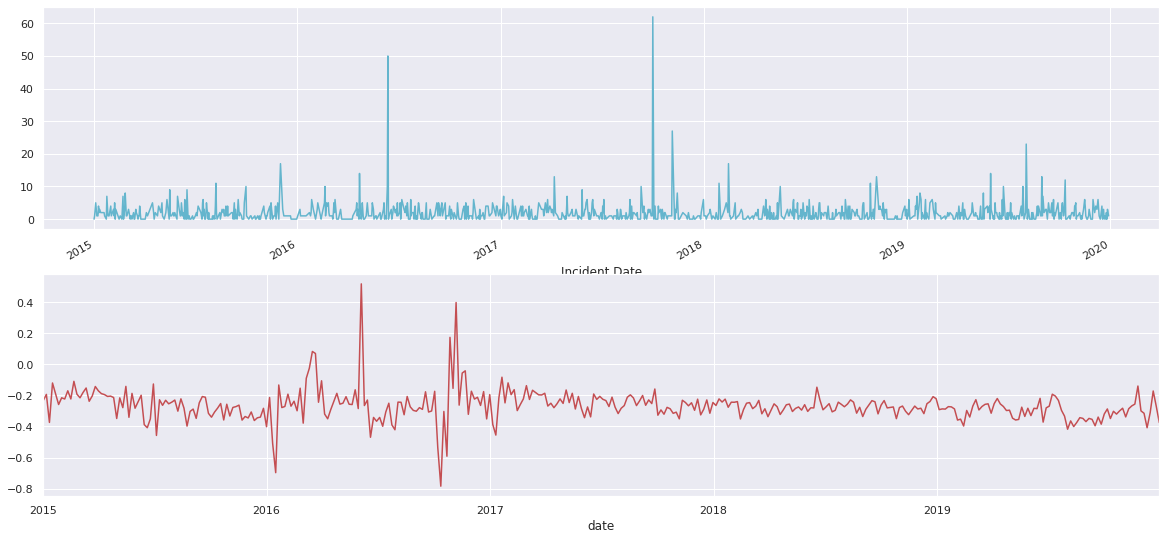

In [ ]:
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(40, 15)
gg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
ppp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

prob a lot of oscillations intra day so maybe try to do rolling avg or smth

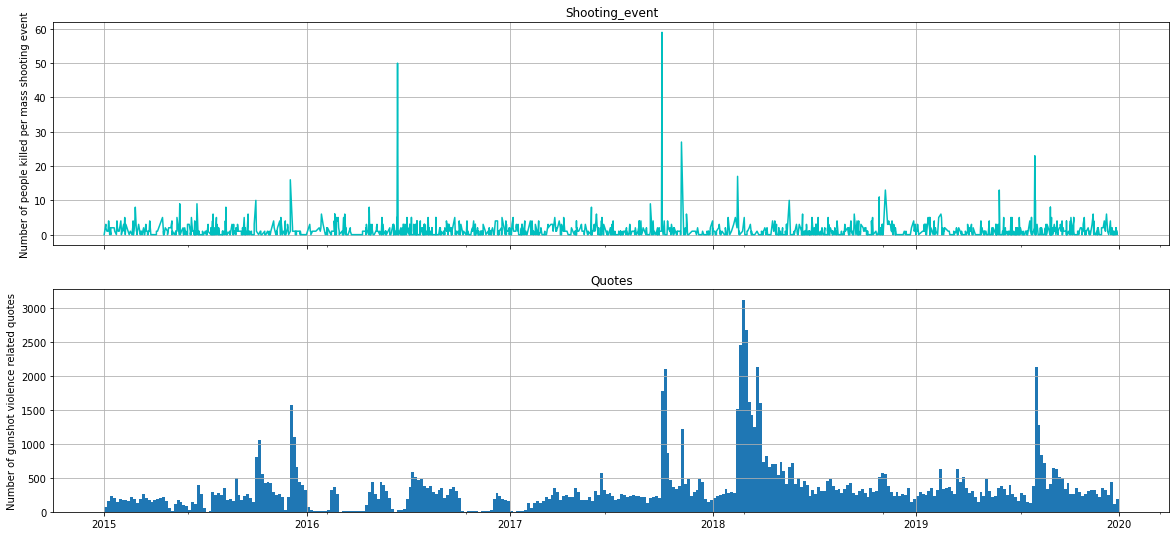

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
quotes['date'].hist(figsize=(20,10), bins = 350, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

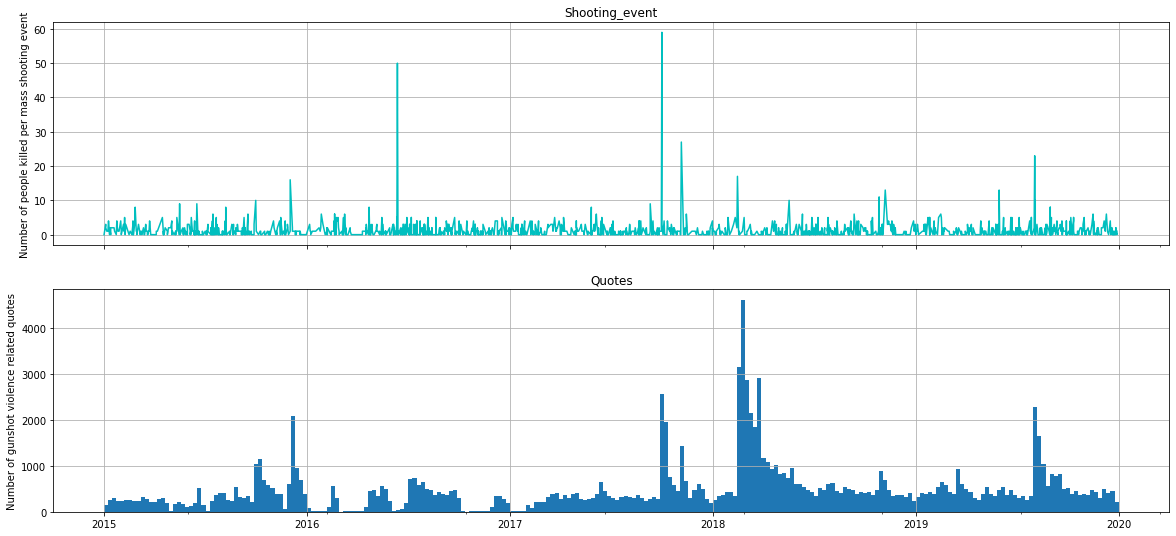

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
quotes['date'].hist(figsize=(20,10), bins = 250, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

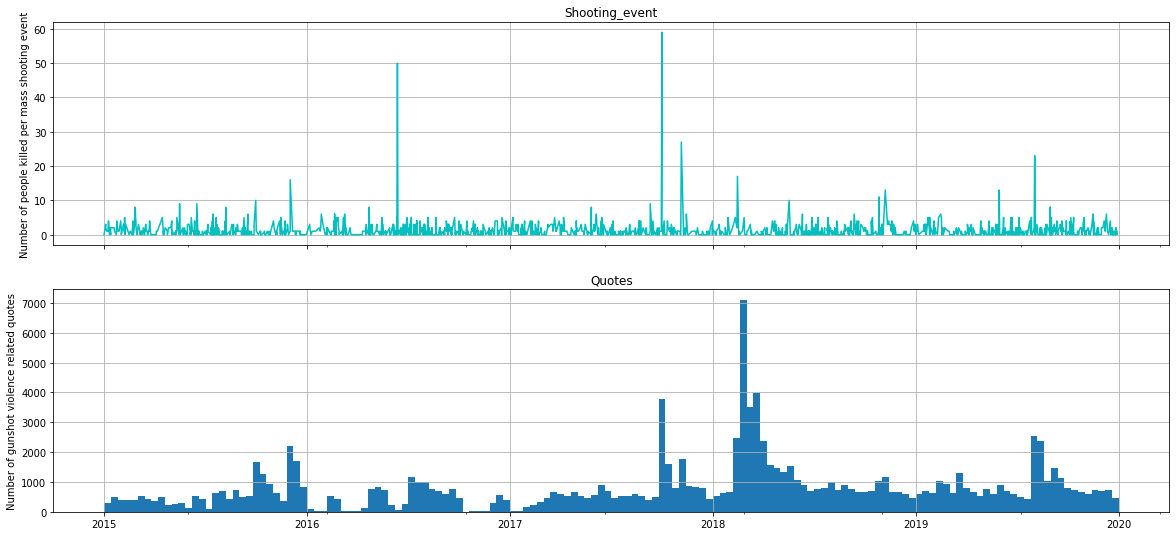

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
quotes['date'].hist(figsize=(20,10), bins = 150, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

From a visual inspection there seems to be some rough correlation (with those more or less corresponding peaks, exception raised for the second highest peak in the shooting event dataset) between the number of people killed per shooting event and a relatively high number of gunshot violence related quotes in similar dates.


Finished